# Compare Contrail Signature Between GOES-West vs GOES-East
---

**Hypothesis:** Clouds such as contrails should have a larger signal-to-noise ratio in GOES-West in the morning and GOES-East in the evening due to Mie scattering.


In [2]:
import os
if os.getcwd() == '/content':
    print("You are working in a Google colab notebook!\nLet's grab data and code from github.\n")
    !rm -r Get_GOES scripts figures data
    !git clone https://github.com/reykoki/Get_GOES.git
    !rm Get_GOES/Get_GOES.ipynb
    !mv Get_GOES/* .
    !pip install -r requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
from datetime import datetime
import pytz
import pyproj
import sys
sys.path.insert(1, './scripts')
from helper_functions import *
from satpy.writers import get_enhanced_image
import cartopy.crs as ccrs
from satpy import Scene
from pyresample import create_area_def
from grab_goes import download_goes # ./scripts/grab_goes.py
from plot_tifs import * # ./scripts/plot_tifs.py


In [3]:
def get_lat_lon_dt_from_url(url):
    lat = str(np.round(float(url.split('latitude=')[-1].split('&')[0]),2))
    lon = str(np.round(float(url.split('longitude=')[-1].split('&')[0]),2))
    dt = pytz.utc.localize(datetime.utcfromtimestamp(int(url.split('time=')[-1])))
    return lat, lon, dt


def normalize(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
    #return data


def get_proj():
    lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                     central_latitude=38.5,
                                     standard_parallels=(38.5, 38.5),
                                     globe=ccrs.Globe(semimajor_axis=6371229,
                                                      semiminor_axis=6371229))
    return lcc_proj


# get the Satpy Scene object
def get_scn(fns, to_load, extent, res=3000, proj=get_proj(), reader='abi_l1b', print_info=False):
    scn = Scene(reader=reader, filenames=fns)  
    scn.load(to_load, generate=False)
    my_area = create_area_def(area_id='my_area',
                              projection=proj,
                              resolution=res,
                              area_extent=extent
                              )
    if print_info:
        print("Available channels in the Scene object:\n", scn.available_dataset_names())
        print("\nAvailable composites:\n", scn.available_composite_names())
        print("\nArea definitition:\n",my_area)    
    new_scn = scn.resample(my_area) # resamples datasets and resturns a new scene object
    return new_scn

def get_RGB(scn, composite):
    RGB = get_enhanced_image(scn[composite]).data.compute().data
    RGB = np.einsum('ijk->jki', RGB)
    RGB[np.isnan(RGB)] = 0
    RGB[:,:,0] = normalize(RGB[:,:,0])
    RGB[:,:,1] = normalize(RGB[:,:,1])
    RGB[:,:,2] = normalize(RGB[:,:,2])

    return RGB

def save_data(data, band, fn_head):
    tif_fn_data = data_dir + 'data/{}_{}.tif'.format(band, fn_head)
    skimage.io.imsave(tif_fn_data, data)
    print("saved file: {}".format(tif_fn_data))

def save_coords(lat, lon, fn_head):
    tif_fn_coords = data_dir + 'coords/{}.tif'.format(fn_head)
    coords_layers = np.dstack([lat, lon])
    skimage.io.imsave(tif_fn_coords, coords_layers)
    print("saved file: {}".format(tif_fn_coords))

def get_extent(lat, lon, res, img_size=128): # img_size - number of pixels
    lcc_proj = pyproj.Proj(get_proj())
    center = lcc_proj(lon,lat)
    dist = int(img_size/2*res)
    x0 = center[0] - dist
    y0 = center[1] - dist
    x1 = center[0] + dist
    y1 = center[1] + dist
    return [x0, y0, x1, y1]

def create_raw(sat_fns, lat, lon, res=2000): # res is resolution in km
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    bands = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
    scn = get_scn(sat_fns, bands, extent, res)
    lons, lats = scn[bands[0]].attrs['area'].get_lonlats()
    for band in bands:
        save_data(scn[band].data, band, fn_head)
    save_coords(lats, lons, fn_head)
    return fn_head, scn
    
def create_composite(sat_fns, lat, lon, composites = ['cimss_true_color_sunz_rayleigh', 'airmass'], res=2000):
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    scn = get_scn(sat_fns, composites, extent, res)
    lons, lats = scn[composites[0]].attrs['area'].get_lonlats()
    for composite in composites:
        data = get_RGB(scn, composite)
        
        save_data(data, composite, fn_head)
    save_coords(lats, lons, fn_head)
    return fn_head, scn   

def plot_composite(composite, fn_head, data_loc="./data/"):
    data_fn = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head))[0]
    coords_fn = glob("{}coords/{}.tif".format(data_loc, fn_head))[0]
    print(get_datetime_from_fn(coords_fn))
    RGB = skimage.io.imread(data_fn, plugin='tifffile')
    lat, lon = get_lat_lon(coords_fn)
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(RGB)
    plt.yticks(np.linspace(0,RGB.shape[0]-1,len(lat)), np.round(lat,2), fontsize=12)
    plt.ylabel('latitude (degrees)', fontsize=16)
    plt.xticks(np.linspace(0,RGB.shape[0]-1,len(lon)), np.round(lon,2), fontsize=12)
    plt.xlabel('longitude (degrees)', fontsize=16)
    #plt.title(composite,fontsize=24)
    plt.title('GOES-East',fontsize=24)
    plt.tight_layout(pad=0)
    plt.show()

def plot_composite_W_E(composite, fn_head_W, fn_head_E, data_loc="./data/", save_fig_name = None):
    data_fn_W = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head_W))[0]
    data_fn_E = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head_E))[0]
    coords_fn = glob("{}coords/{}.tif".format(data_loc, fn_head_W))[0]
    print(get_datetime_from_fn(coords_fn))
    RGB_W = skimage.io.imread(data_fn_W, plugin='tifffile')
    RGB_E = skimage.io.imread(data_fn_E, plugin='tifffile')
    lat, lon = get_lat_lon(coords_fn)
    fig, ax = plt.subplots(1, 2, figsize=(15,30),dpi=300)
    ax[0].imshow(RGB_W)
    ax[1].imshow(RGB_E)
    ax[0].set_yticks(np.linspace(0, RGB_W.shape[0]-1,len(lat)), np.round(lat,2), fontsize=12)
    ax[0].set_ylabel('latitude (degrees)', fontsize=20)
    ax[0].set_xticks(np.linspace(0,RGB_E.shape[0]-1,len(lon)), np.round(lon,2), fontsize=12)
    ax[0].set_xlabel('longitude (degrees)', fontsize=20)
    #plt.title(composite,fontsize=24)
    ax[0].set_title('GOES-West',fontsize=24)
    ax[1].set_title('GOES-East',fontsize=24)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.tight_layout(pad=0)
    if save_fig_name:
        plt.savefig(save_fig_name, dpi=300)
    plt.show()


In [4]:
def composite_GOES(lat, lon, dt_str, sat_num):
    dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M')) # convert to datetime object
    
    sat_fns = download_goes(dt, scope='F', sat_num=sat_num, bands = [2,4,5])
    #fn_head, scn = create_raw(sat_fns, lat, lon, res=2000)
    #plot_all_bands(fn_head)
    #composites = ['colorized_ir_clouds', 'cimss_cloud_type', 'airmass','cimss_true_color_sunz_rayleigh']
    composites = ['cimss_cloud_type']
    fn_head, scn = create_composite(sat_fns, lat, lon, composites)

    return fn_head, composites
def composite_GOES_W_E(lat, lon, dt, composites = ['ash']):
    sat_fns_E = download_goes(dt, scope='F', sat_num='16')
    sat_fns_W = download_goes(dt, scope='F', sat_num='18')
    fn_head_W, scn = create_composite(sat_fns_W, lat, lon, composites)
    fn_head_E, scn = create_composite(sat_fns_E, lat, lon, composites)
    return fn_head_W, fn_head_E, composites


for the datetime 2025-03-11 19:16:16+00:00:
sunrise is at: 2025-03-11 14:33:00+00:00
sunset is at: 2025-03-11 22:44:00+00:00
for the datetime 2025-03-11 19:16:16+00:00:
sunrise is at: 2025-03-11 14:33:00+00:00
sunset is at: 2025-03-11 22:44:00+00:00
saved file: ./data/data/ash_G18_s20250701920218_e20250701929526_40.05_-125.32.tif
saved file: ./data/coords/G18_s20250701920218_e20250701929526_40.05_-125.32.tif
saved file: ./data/data/ash_G16_s20250701920186_e20250701929494_40.05_-125.32.tif
saved file: ./data/coords/G16_s20250701920186_e20250701929494_40.05_-125.32.tif
2025/03/11 19:20 UTC


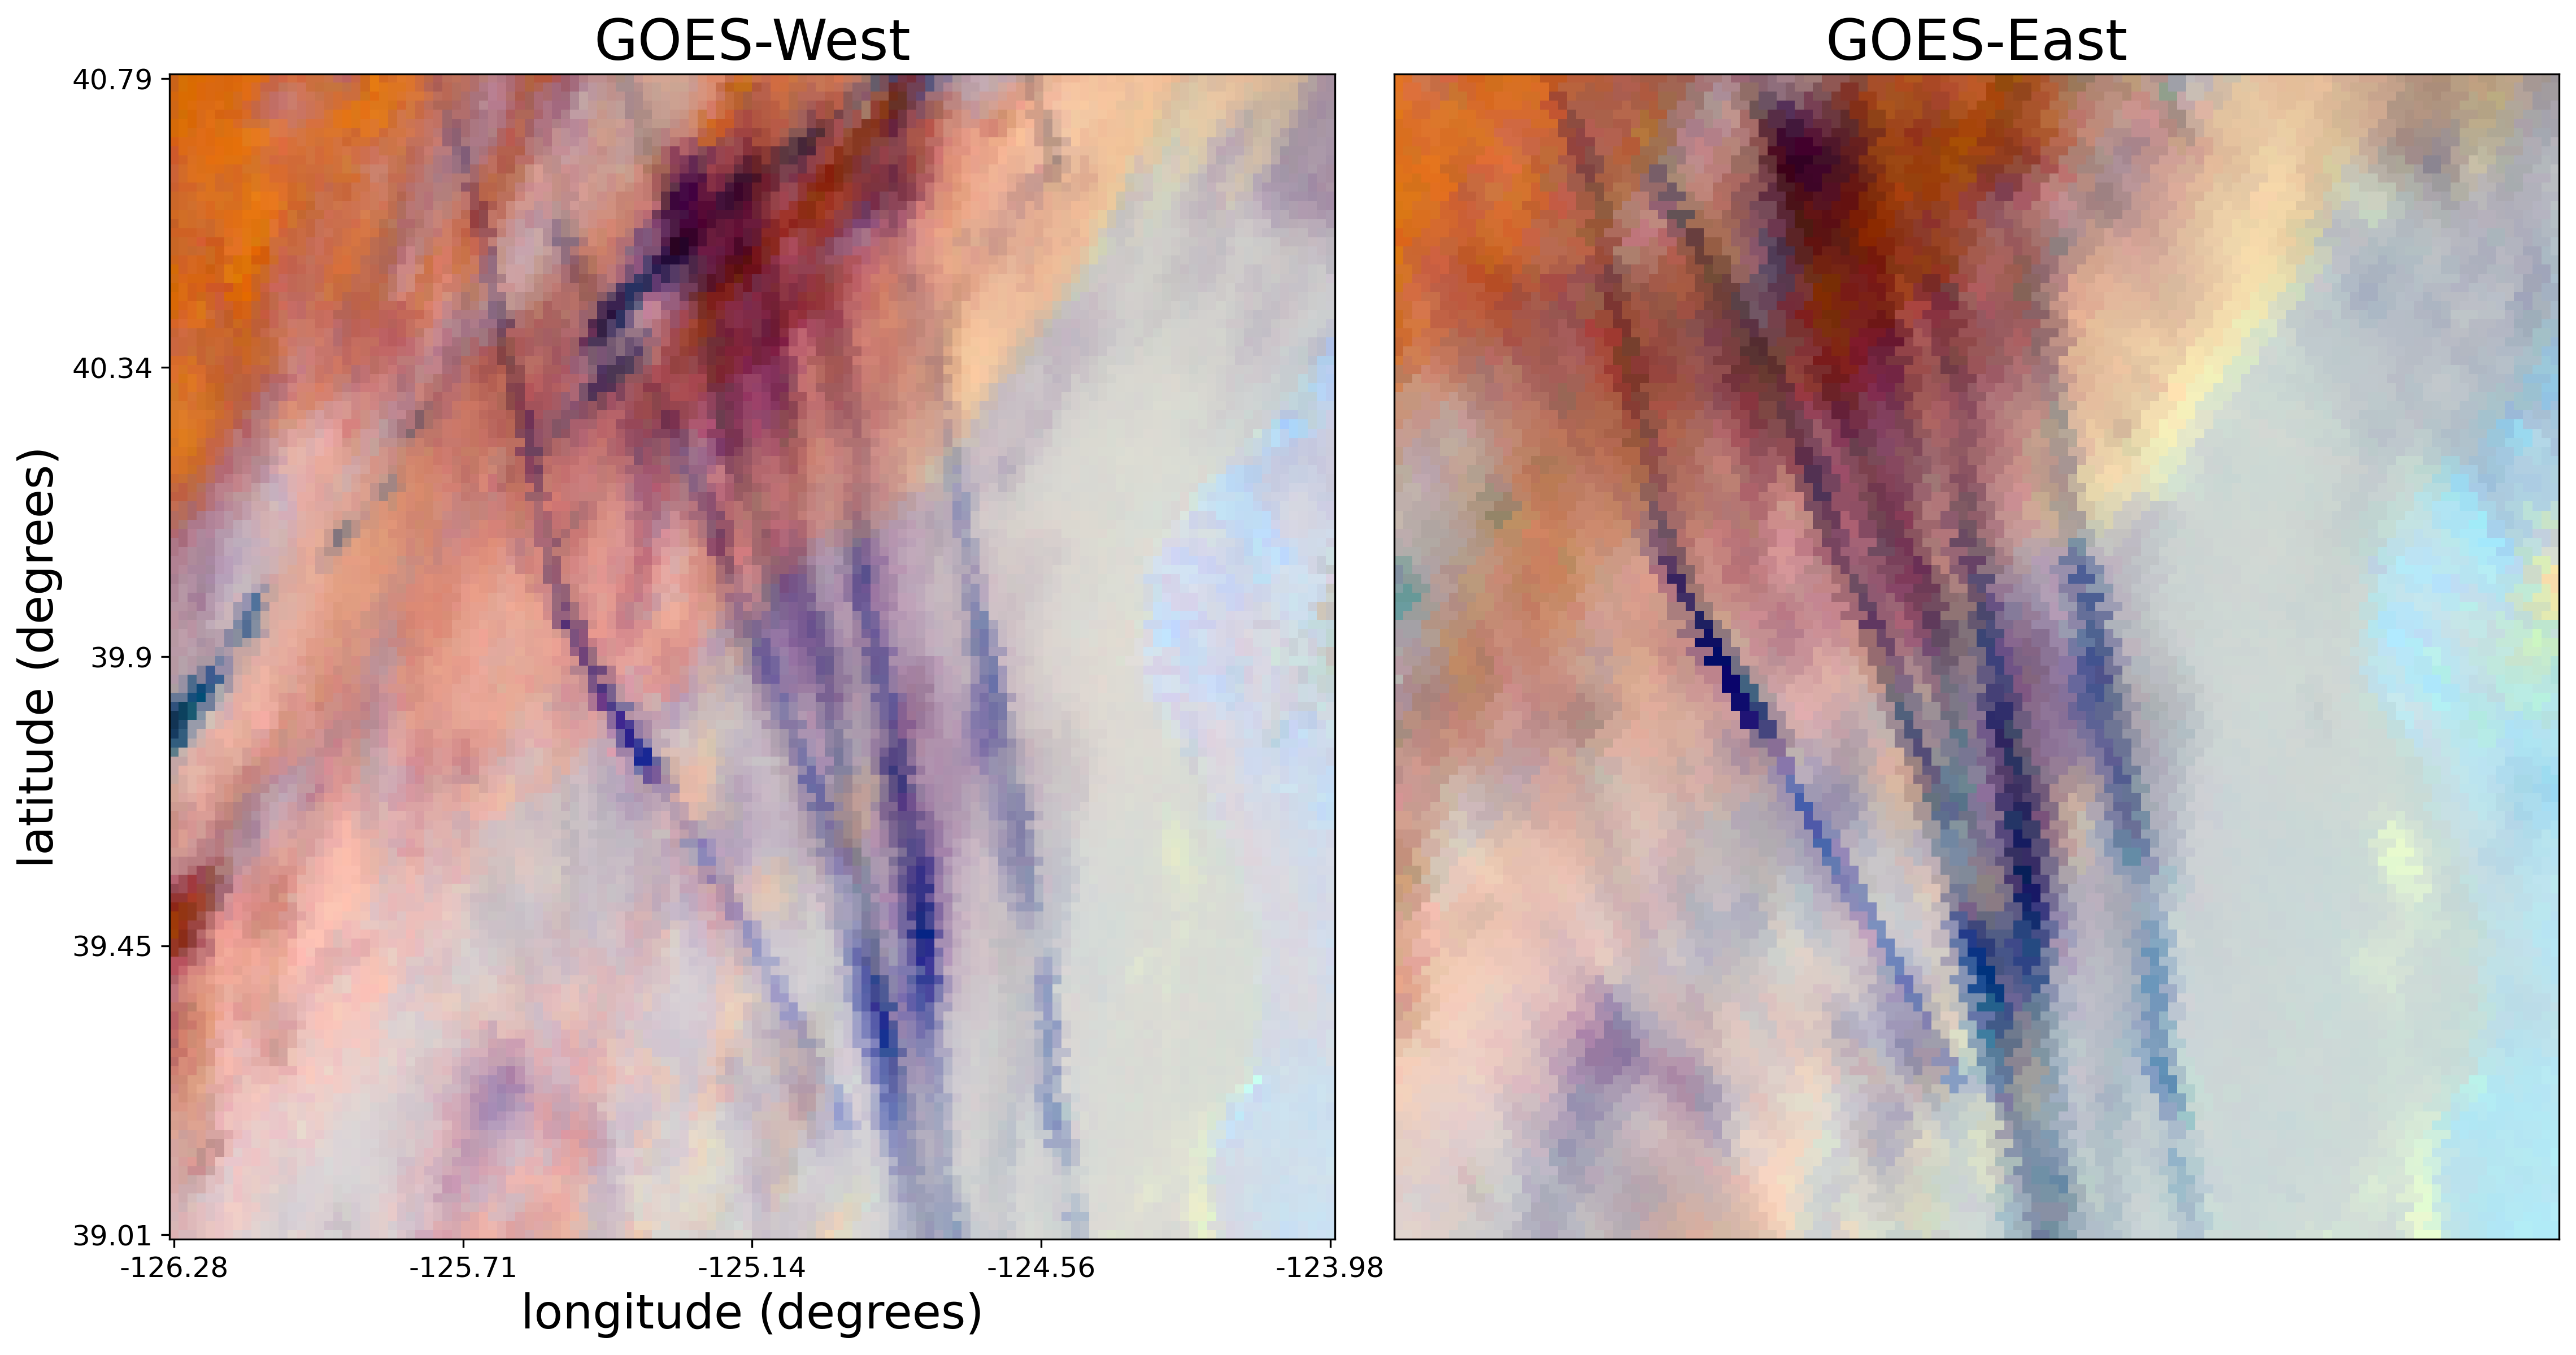

In [6]:

url = 'https://contrails.webapps.google.com/main?latitude=40.050&longitude=-125.318&zoom=34.14&imagetype=cirrus&time=1741720576'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-03-12 04:53:48+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
for the datetime 2025-03-12 04:53:48+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
saved file: ./data/data/ash_G18_s20250710450216_e20250710459524_37.18_-120.52.tif
saved file: ./data/coords/G18_s20250710450216_e20250710459524_37.18_-120.52.tif


/projects/mecr8410/software/anaconda/envs/g2g/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


saved file: ./data/data/ash_G16_s20250710450186_e20250710459494_37.18_-120.52.tif
saved file: ./data/coords/G16_s20250710450186_e20250710459494_37.18_-120.52.tif
2025/03/12 04:50 UTC


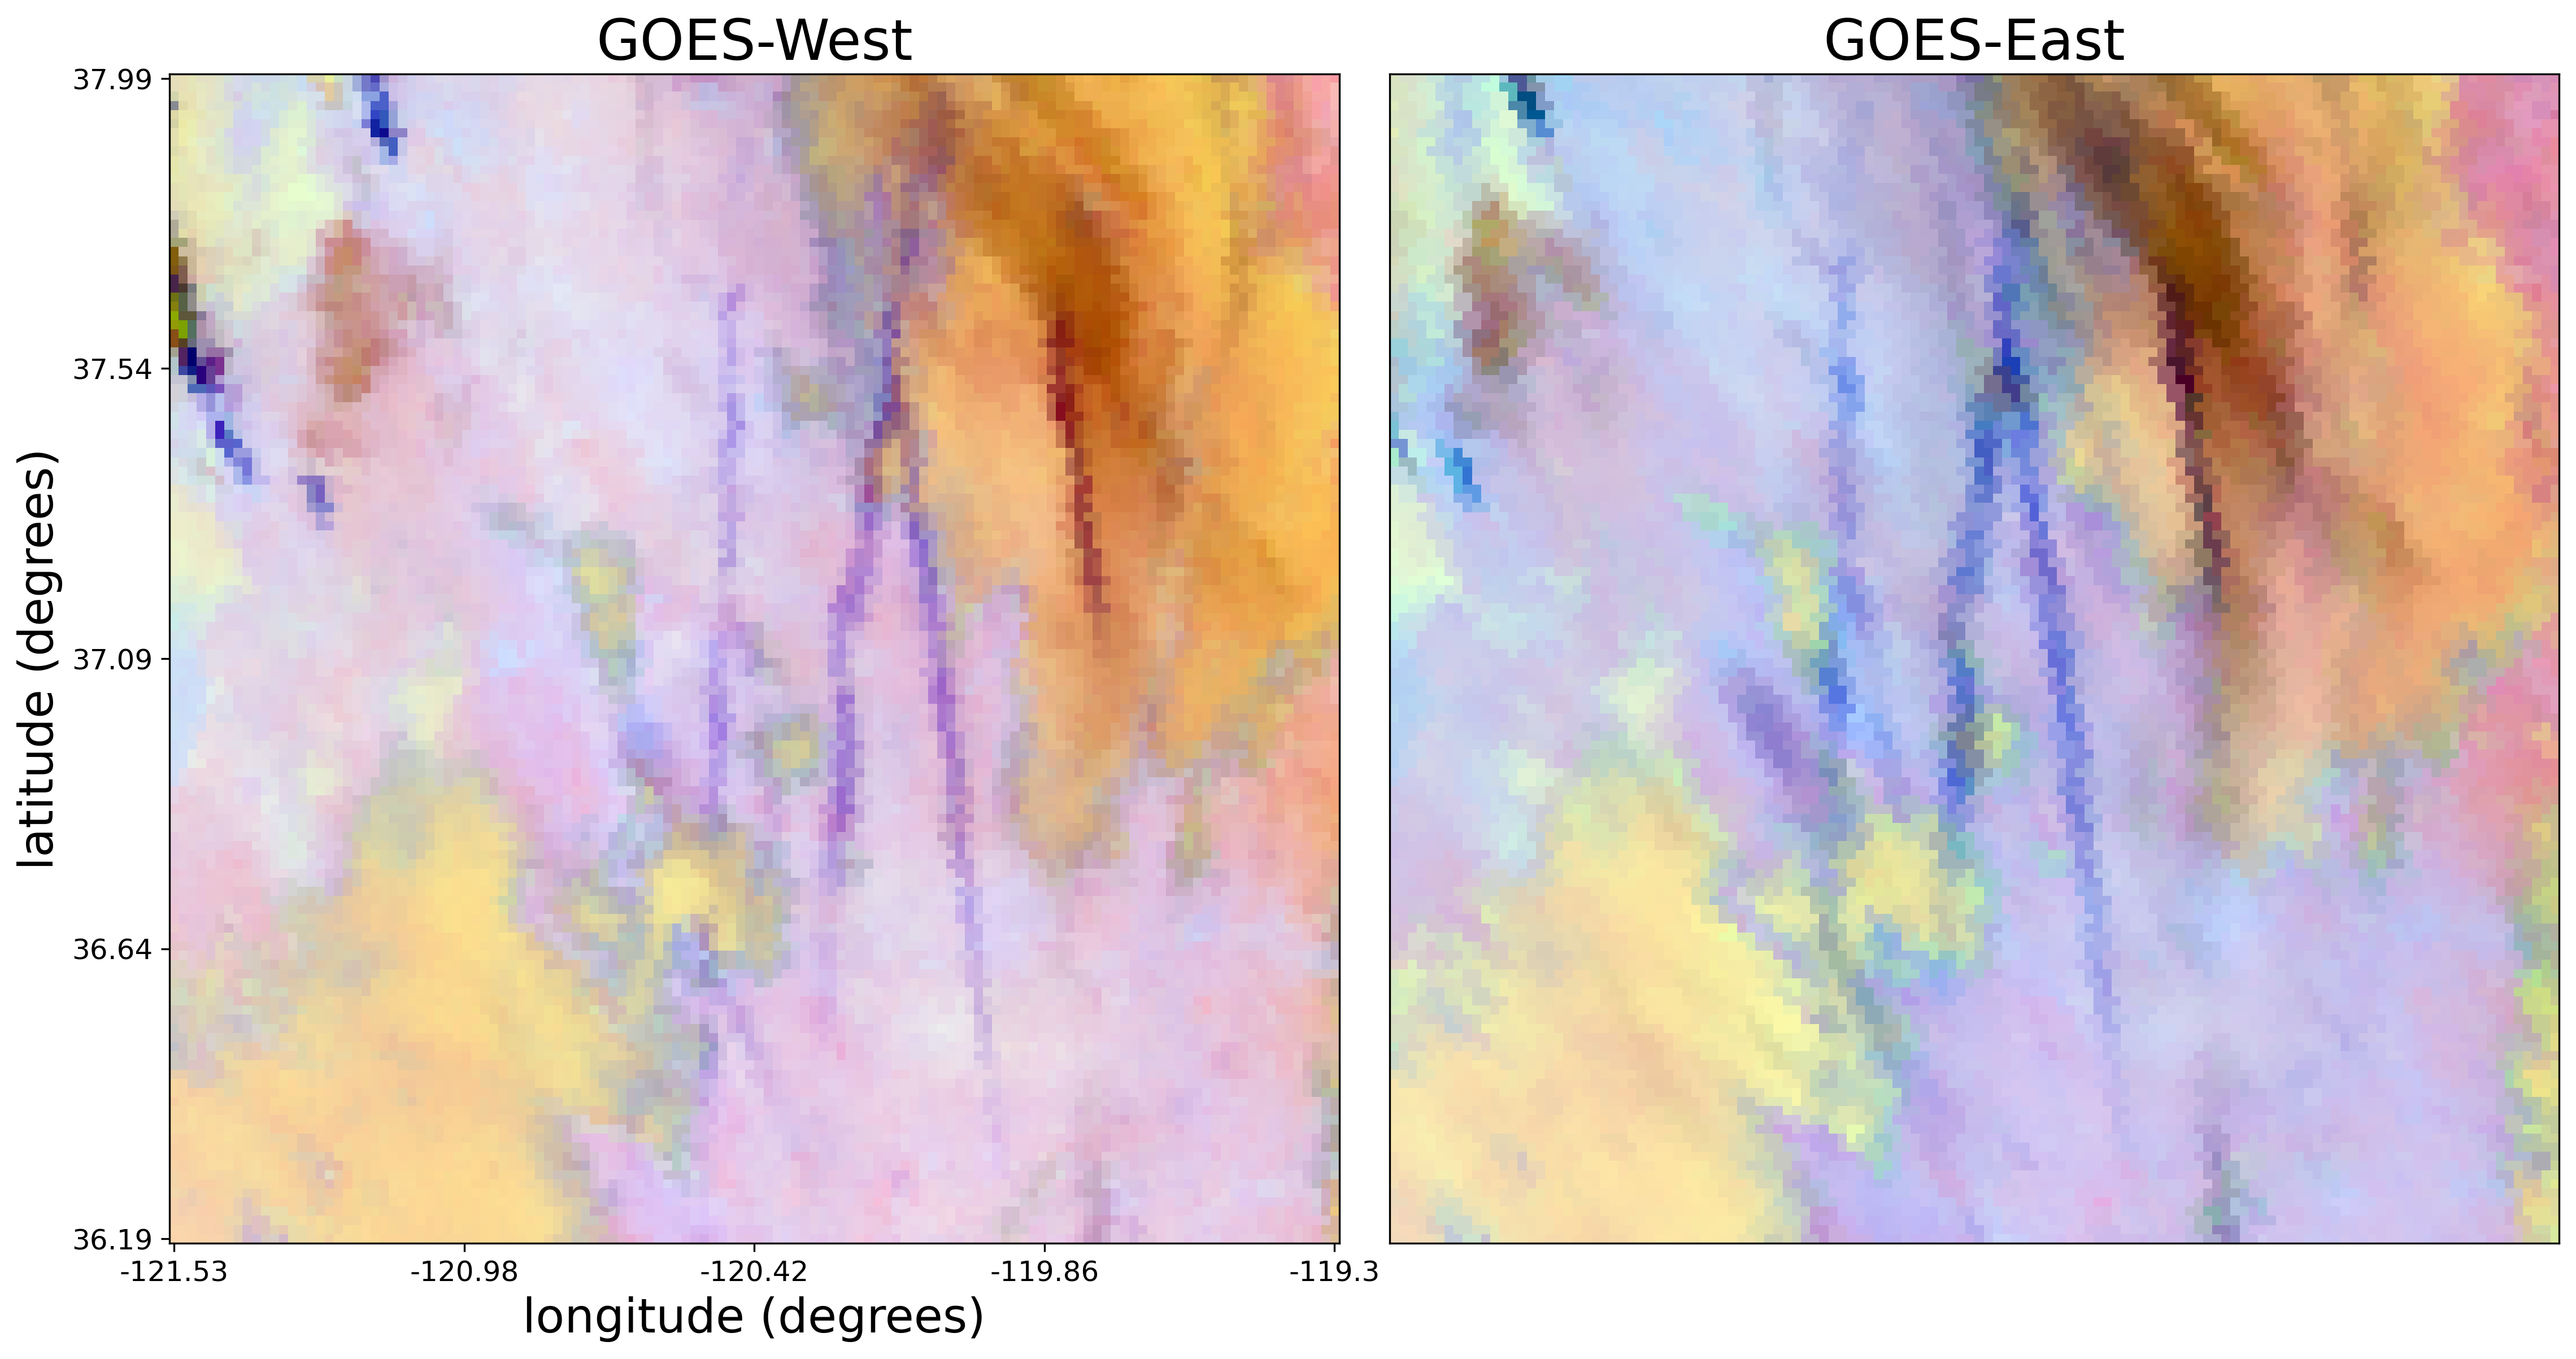

In [9]:
url = 'https://contrails.webapps.google.com/main?latitude=37.185&longitude=-120.517&zoom=10.53&imagetype=cirrus&time=1741755228'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-03-12 10:13:48+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
for the datetime 2025-03-12 10:13:48+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
saved file: ./data/data/ash_G18_s20250711010219_e20250711019527_37.89_-117.03.tif
saved file: ./data/coords/G18_s20250711010219_e20250711019527_37.89_-117.03.tif
saved file: ./data/data/ash_G16_s20250711010188_e20250711019496_37.89_-117.03.tif
saved file: ./data/coords/G16_s20250711010188_e20250711019496_37.89_-117.03.tif
2025/03/12 10:10 UTC


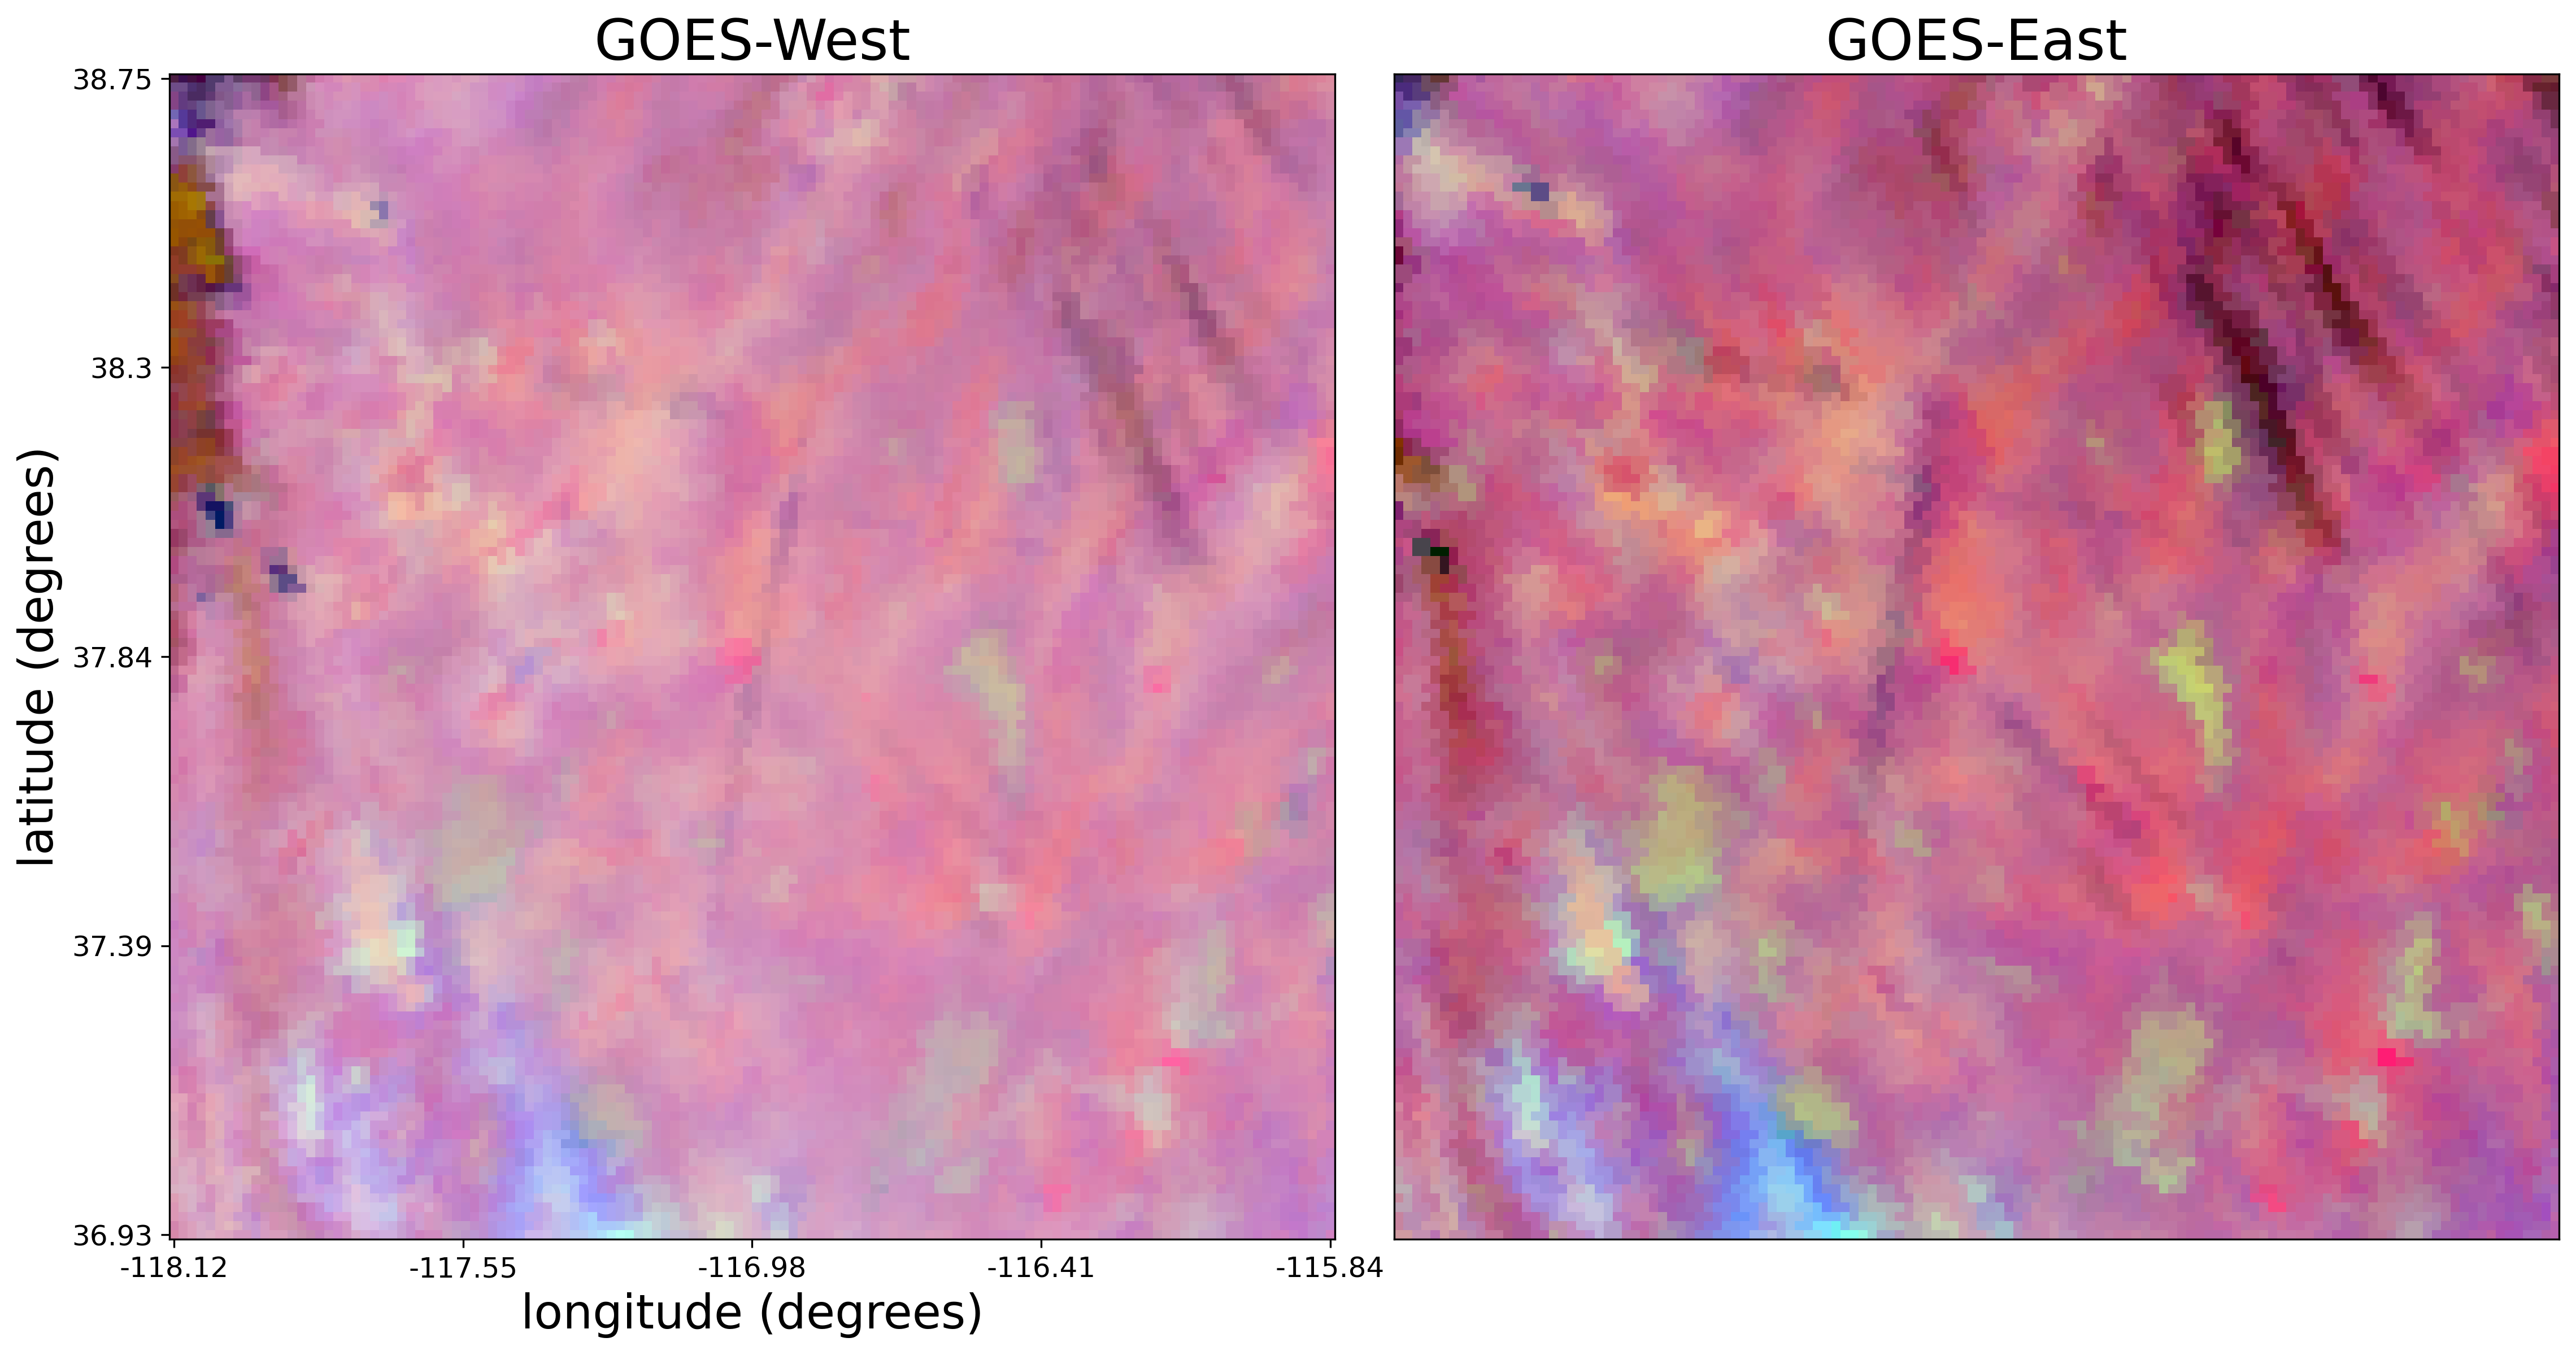

In [10]:
url = 'https://contrails.webapps.google.com/main?latitude=37.887&longitude=-117.027&zoom=41.03&imagetype=cirrus&time=1741774428'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
saved file: ./data/data/ash_G18_s20250711130219_e20250711139527_39.14_-79.74.tif
saved file: ./data/coords/G18_s20250711130219_e20250711139527_39.14_-79.74.tif
saved file: ./data/data/ash_G16_s20250711130188_e20250711139497_39.14_-79.74.tif
saved file: ./data/coords/G16_s20250711130188_e20250711139497_39.14_-79.74.tif
2025/03/12 11:30 UTC


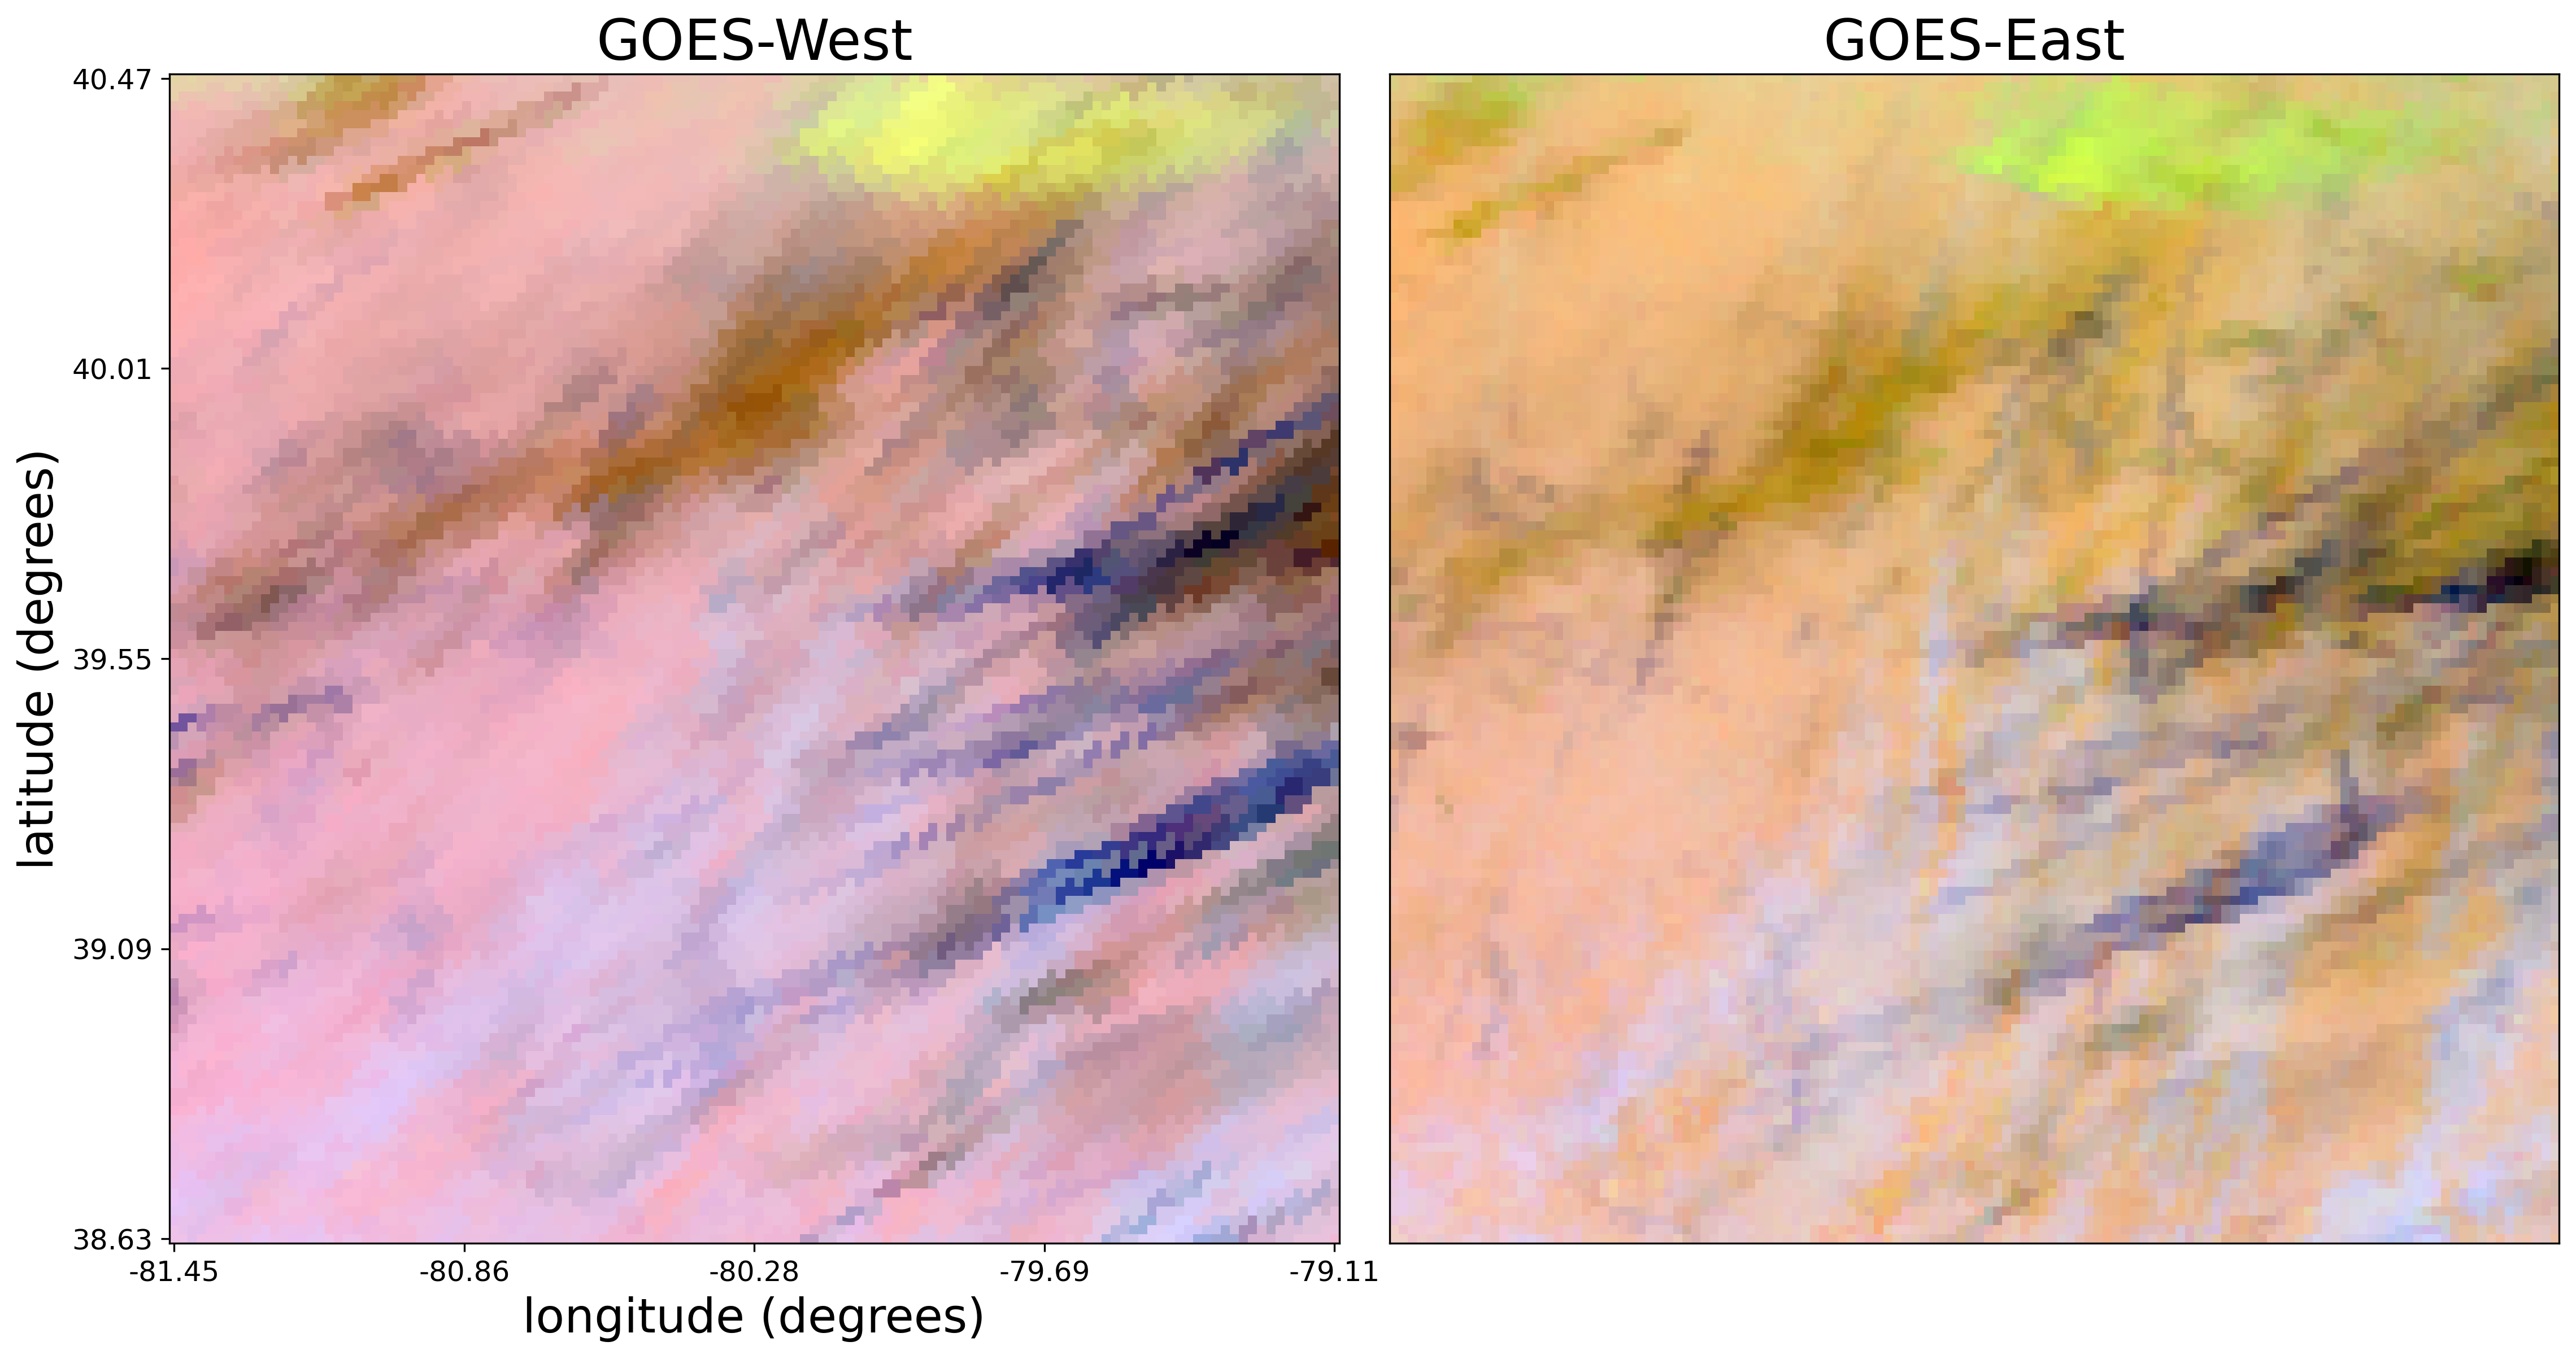

In [11]:
url = 'https://contrails.webapps.google.com/main?latitude=39.138&longitude=-79.745&zoom=15.58&imagetype=cirrus&time=1741779115'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
saved file: ./data/data/ash_G18_s20250711130219_e20250711139527_46.6_-95.88.tif
saved file: ./data/coords/G18_s20250711130219_e20250711139527_46.6_-95.88.tif
saved file: ./data/data/ash_G16_s20250711130188_e20250711139497_46.6_-95.88.tif
saved file: ./data/coords/G16_s20250711130188_e20250711139497_46.6_-95.88.tif
2025/03/12 11:30 UTC


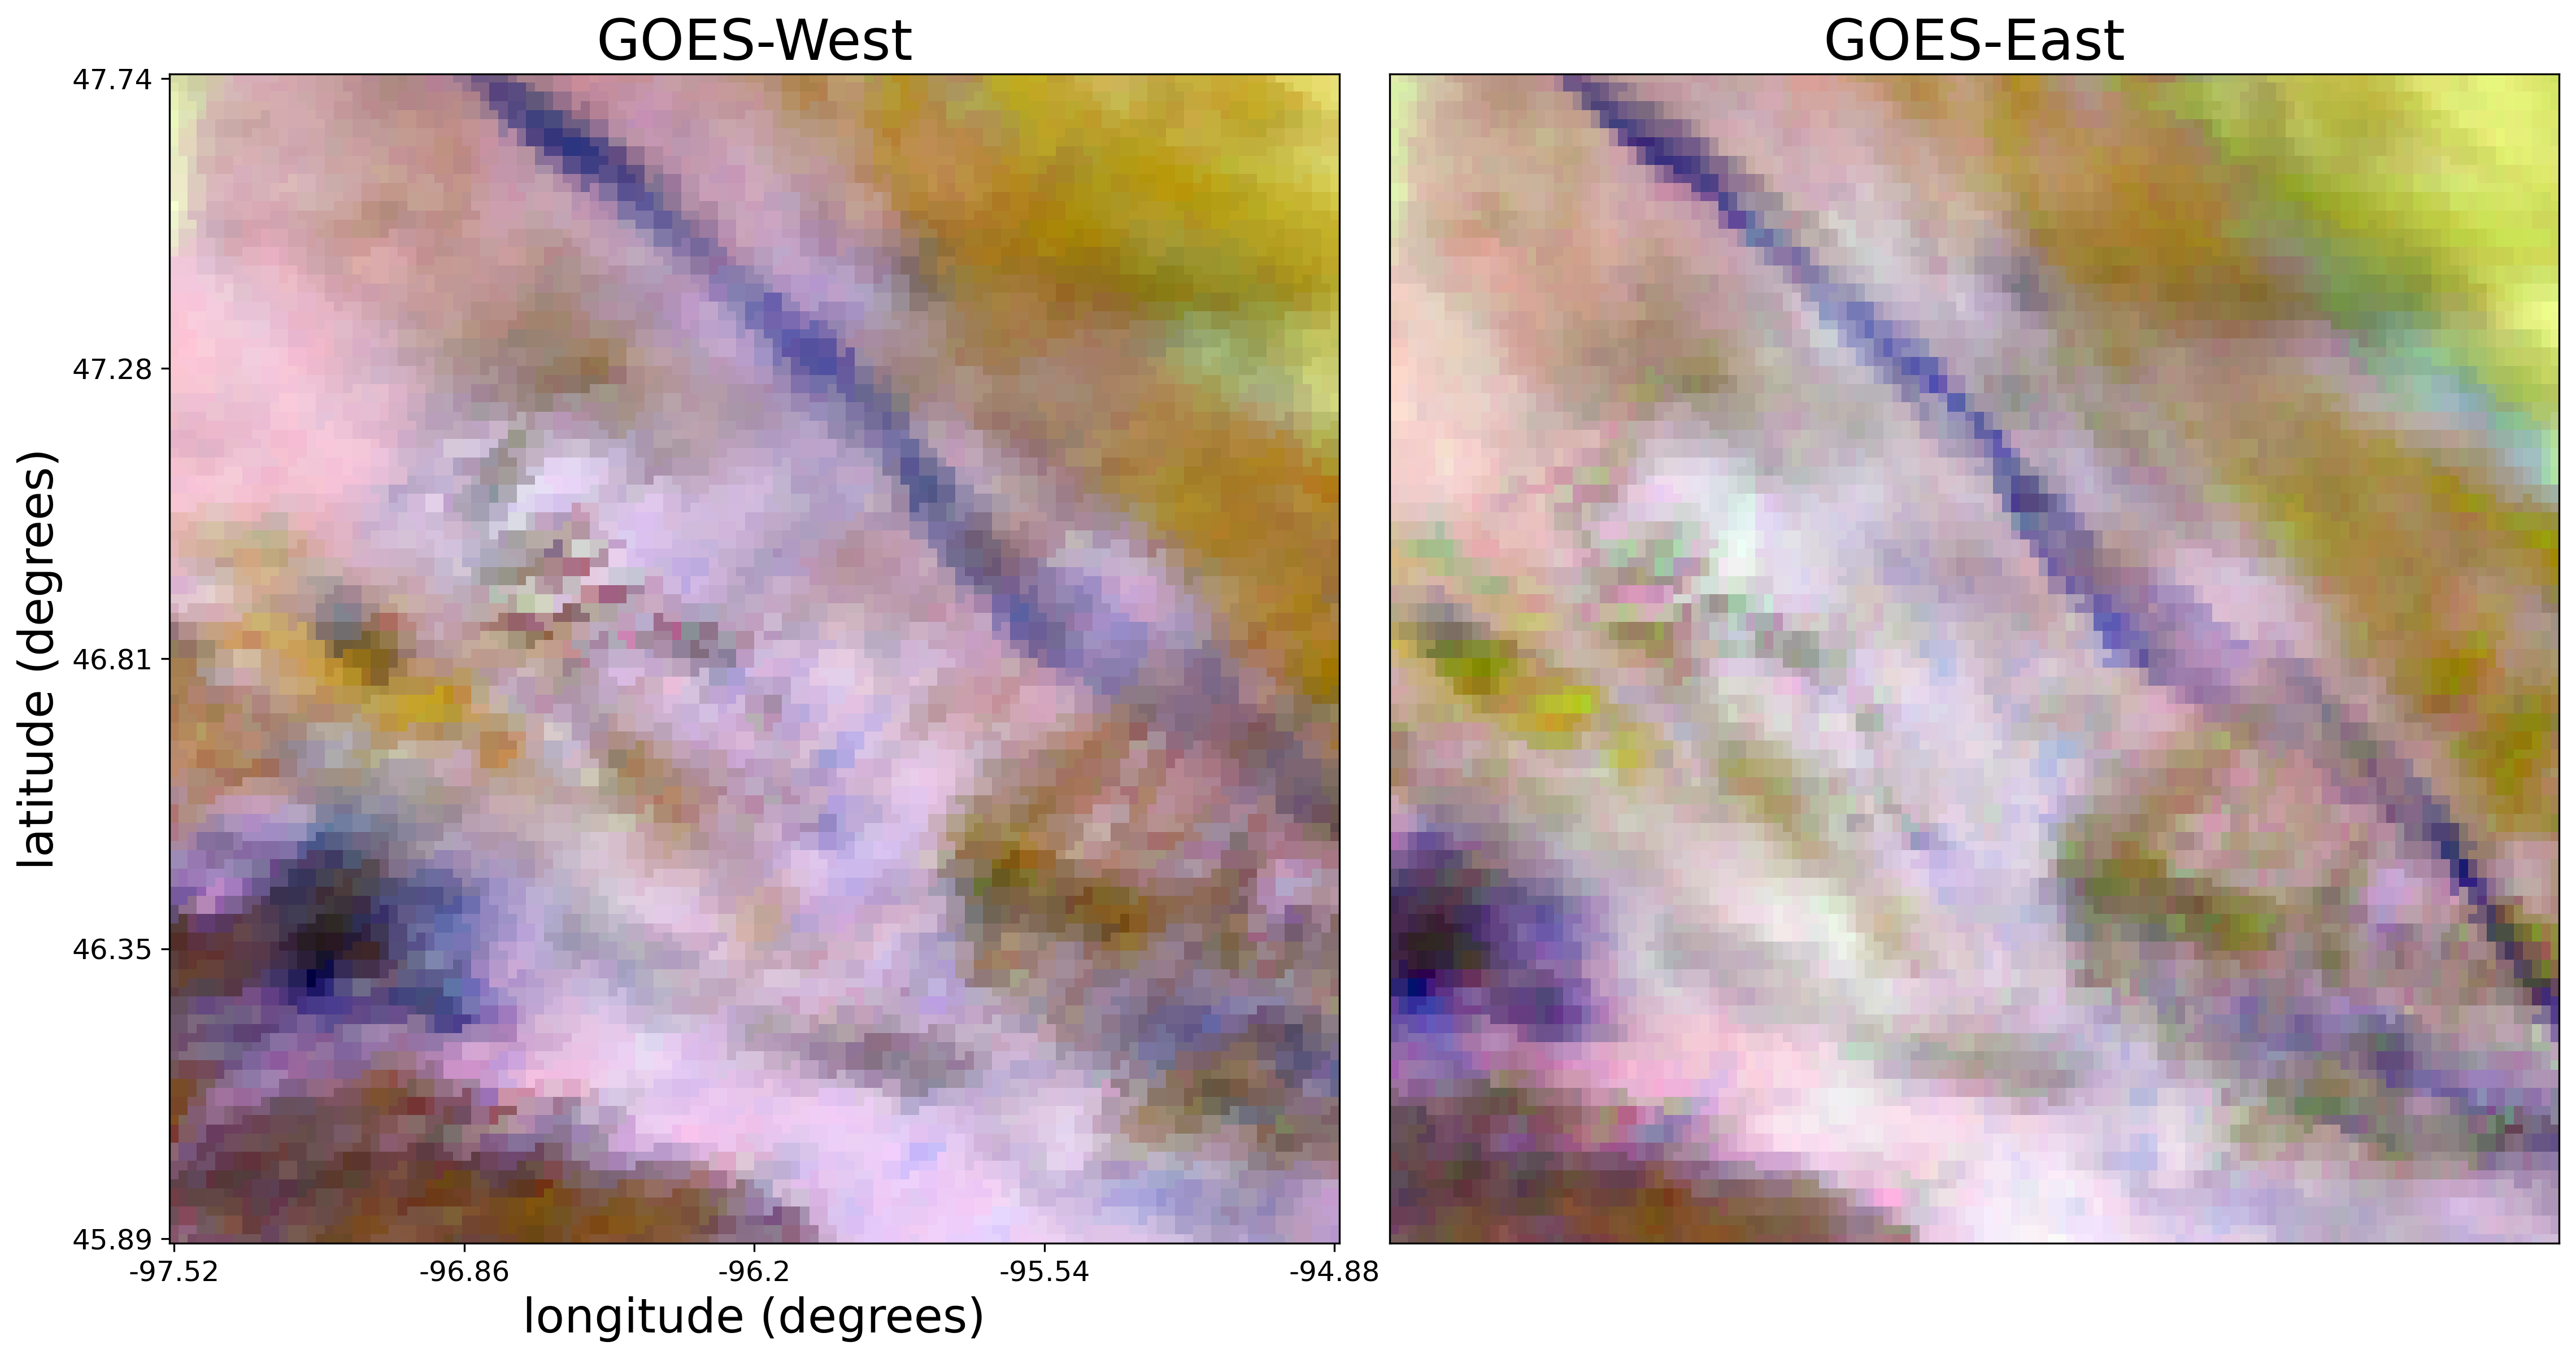

In [12]:
url = 'https://contrails.webapps.google.com/main?latitude=46.600&longitude=-95.884&zoom=10.53&imagetype=cirrus&time=1741779115'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00


/projects/mecr8410/software/anaconda/envs/g2g/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
/projects/mecr8410/software/anaconda/envs/g2g/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


saved file: ./data/data/ash_G18_s20250711130219_e20250711139527_41.64_-74.93.tif
saved file: ./data/coords/G18_s20250711130219_e20250711139527_41.64_-74.93.tif
saved file: ./data/data/ash_G16_s20250711130188_e20250711139497_41.64_-74.93.tif
saved file: ./data/coords/G16_s20250711130188_e20250711139497_41.64_-74.93.tif
2025/03/12 11:30 UTC


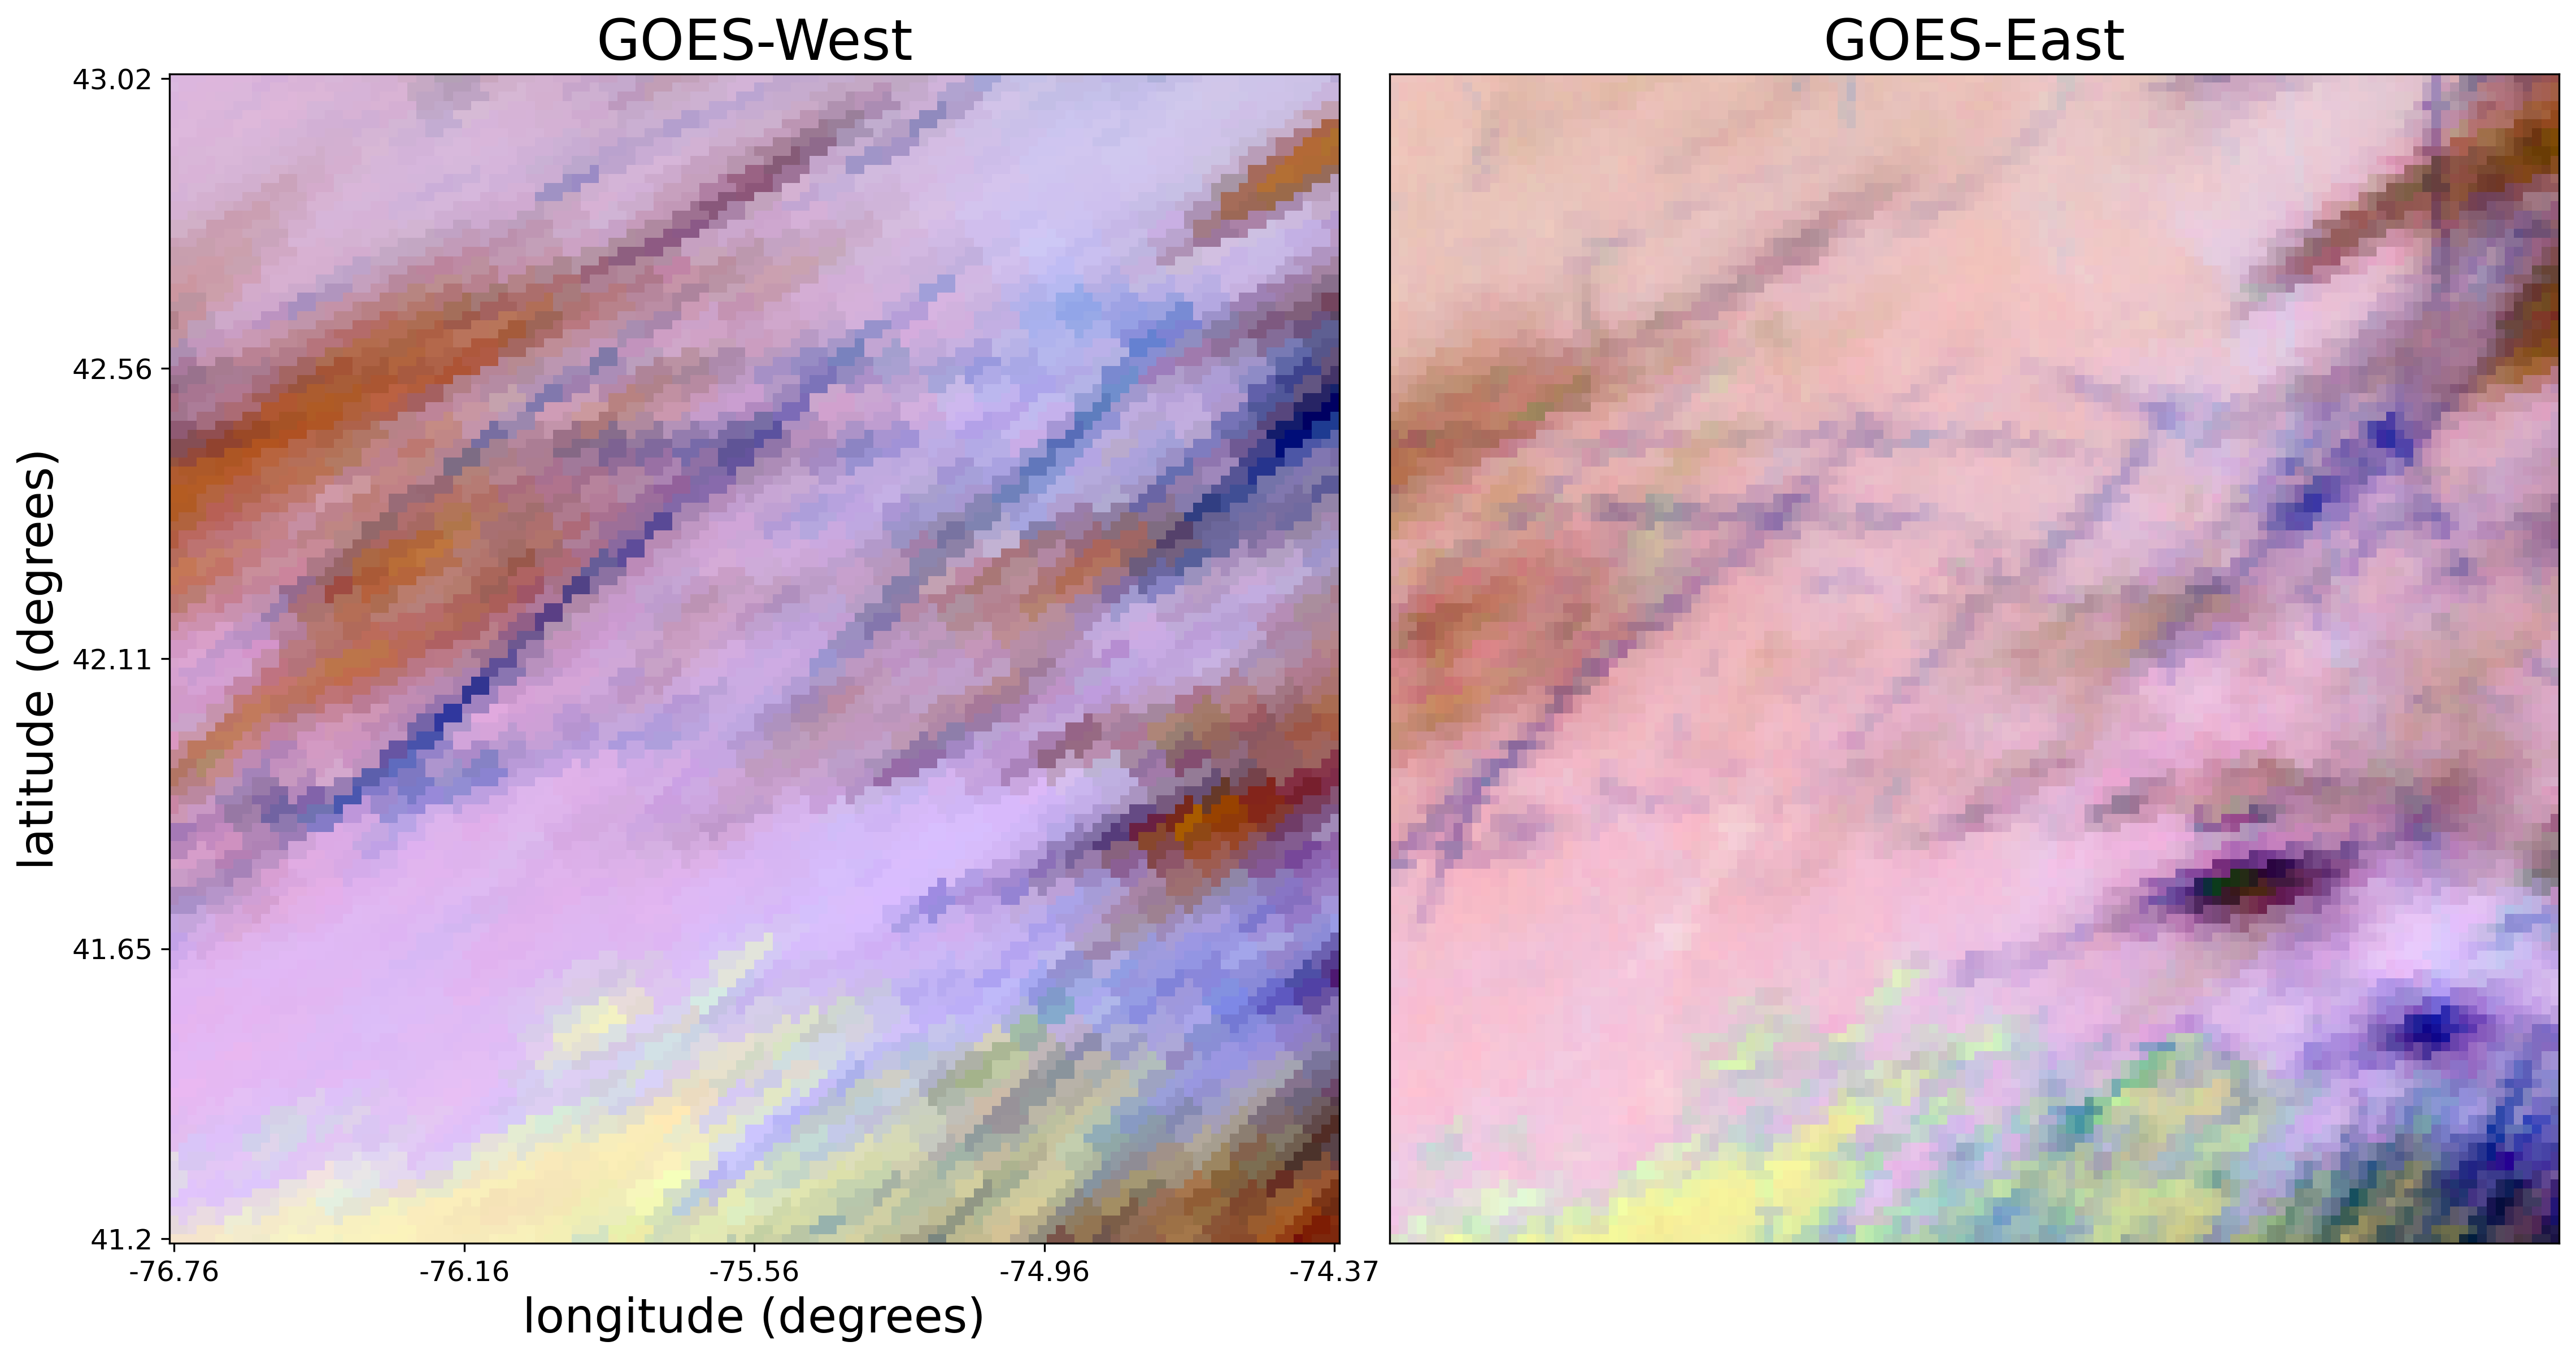

In [15]:
url = 'https://contrails.webapps.google.com/main?latitude=41.635&longitude=-74.929&zoom=15.53&imagetype=cirrus&time=1741779115'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
for the datetime 2025-03-12 11:31:55+00:00:
sunrise is at: 2025-03-12 14:32:00+00:00
sunset is at: 2025-03-12 22:46:00+00:00
saved file: ./data/data/ash_G18_s20250711130219_e20250711139527_30.81_-125.43.tif
saved file: ./data/coords/G18_s20250711130219_e20250711139527_30.81_-125.43.tif
saved file: ./data/data/ash_G16_s20250711130188_e20250711139497_30.81_-125.43.tif
saved file: ./data/coords/G16_s20250711130188_e20250711139497_30.81_-125.43.tif
2025/03/12 11:30 UTC


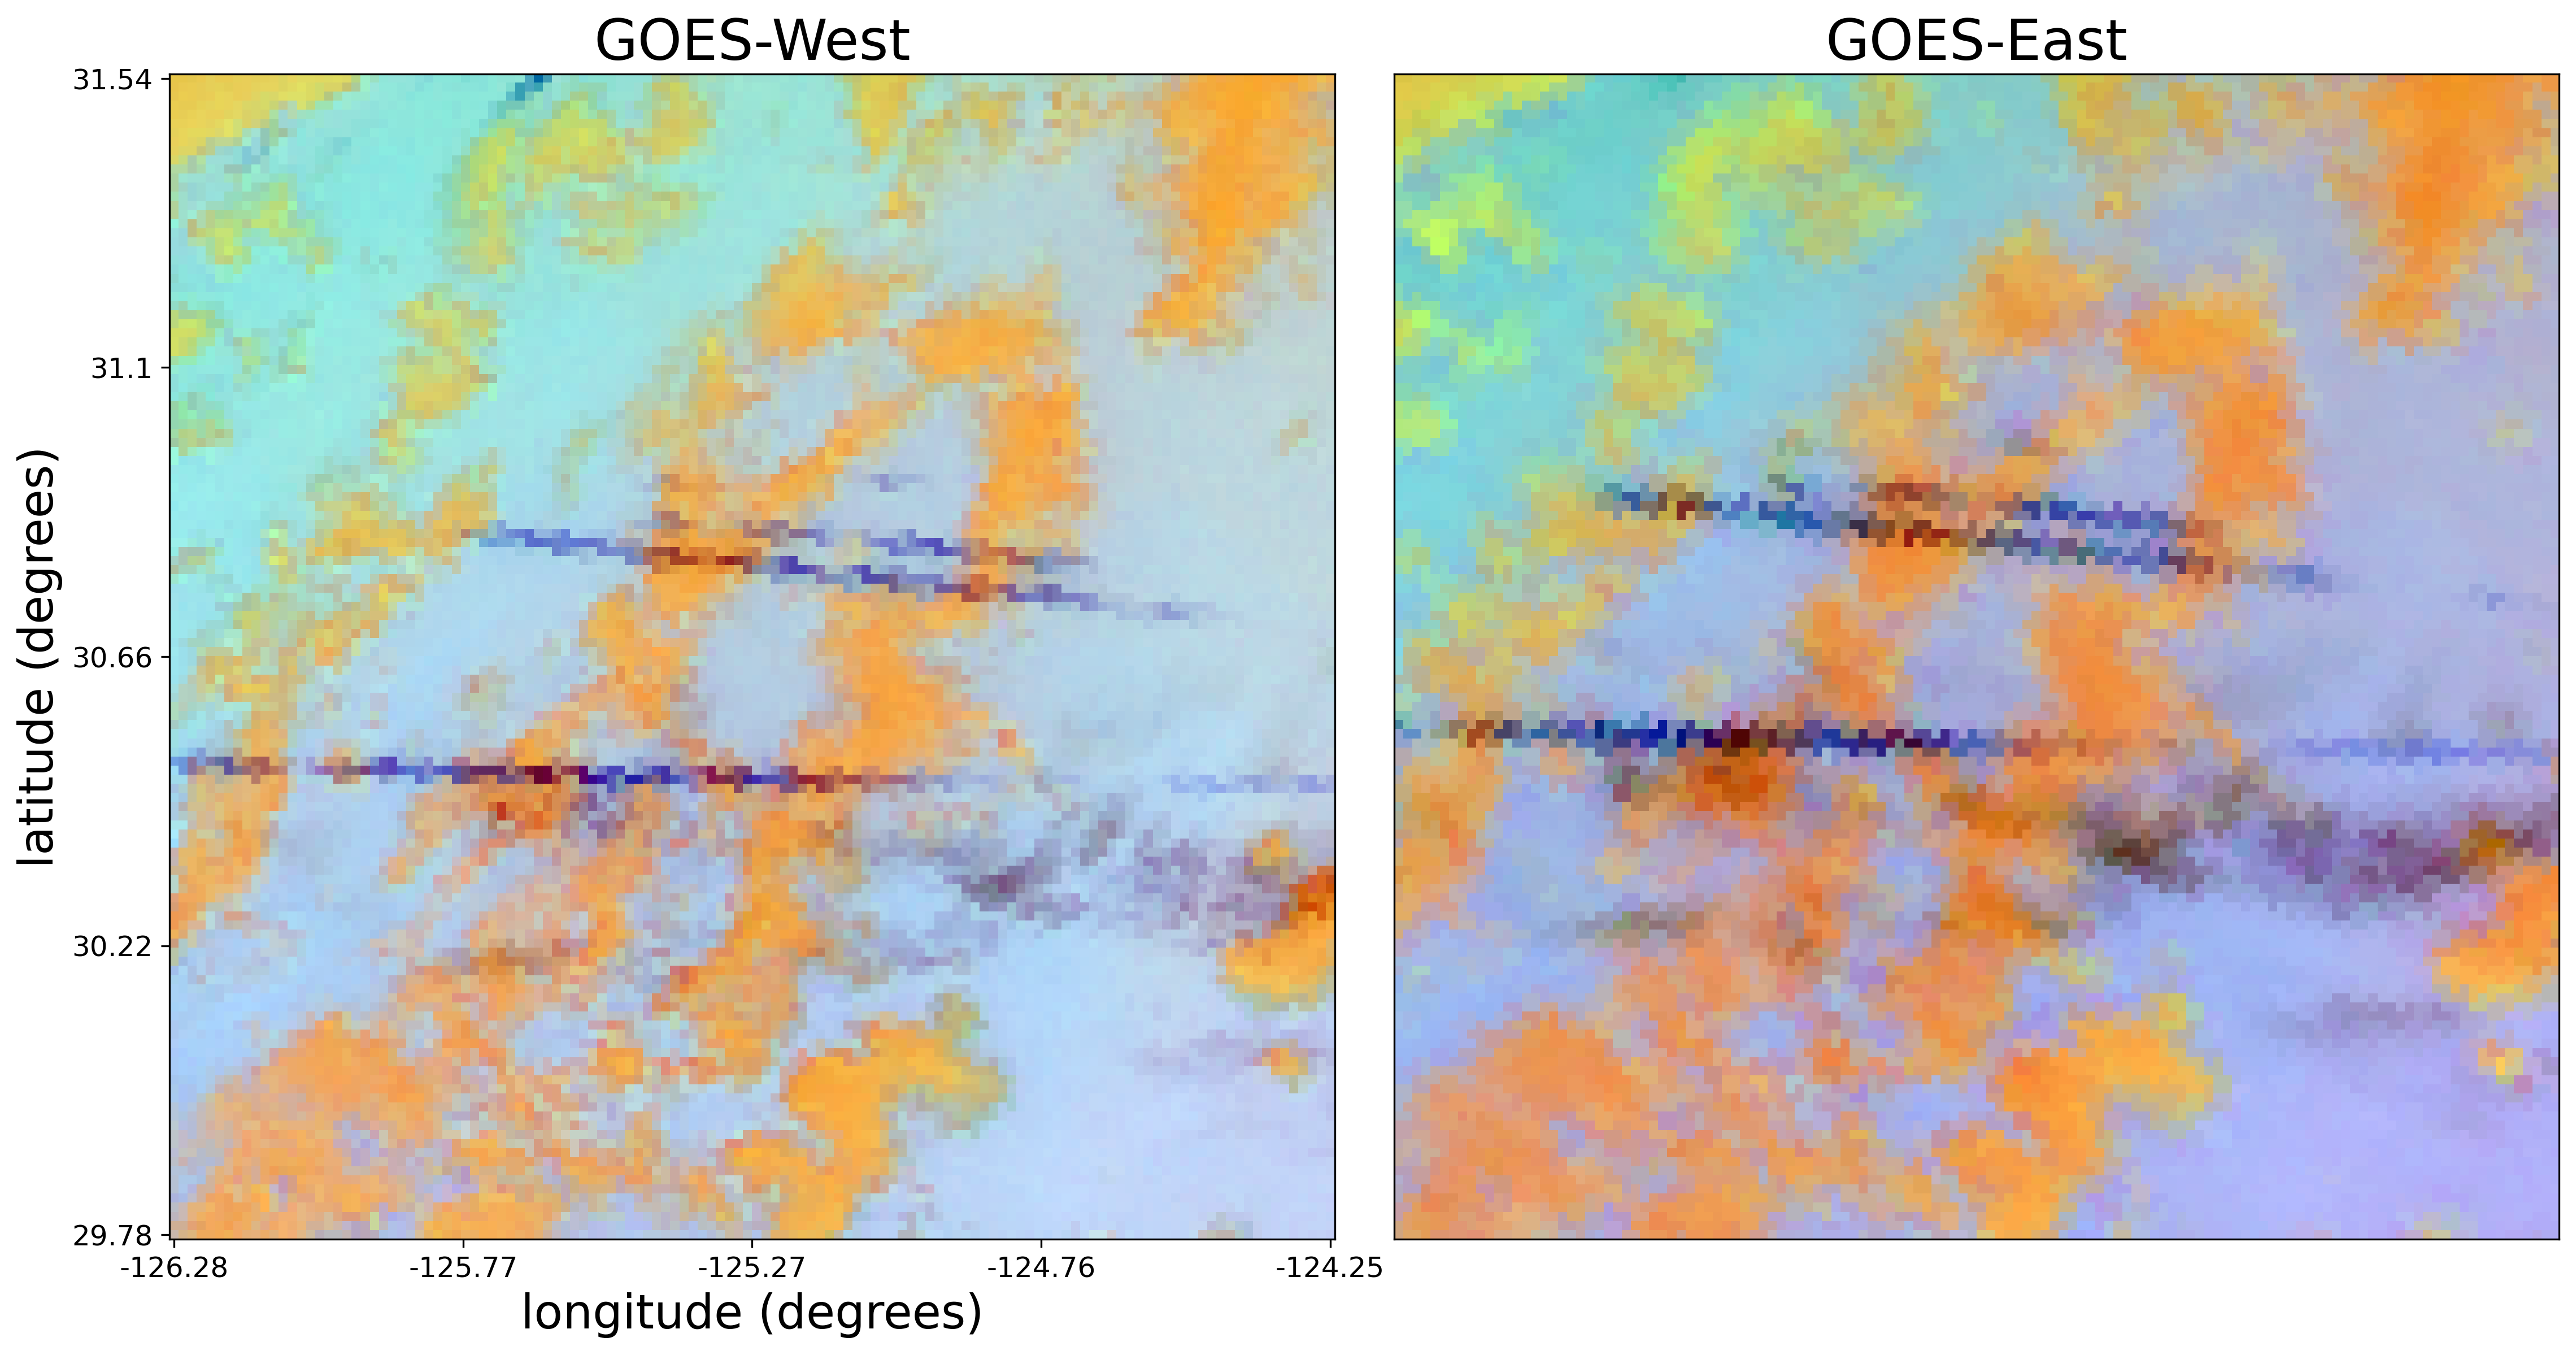

In [14]:
url = 'https://contrails.webapps.google.com/main?latitude=30.813&longitude=-125.433&zoom=50.00&imagetype=cirrus&time=1741779115'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-24 22:33:10+00:00:
sunrise is at: 2025-02-24 14:46:00+00:00
sunset is at: 2025-02-24 22:23:00+00:00
for the datetime 2025-02-24 22:33:10+00:00:
sunrise is at: 2025-02-24 14:46:00+00:00
sunset is at: 2025-02-24 22:23:00+00:00
saved file: ./data/data/ash_G18_s20250552230214_e20250552239522_38.24_-99.39.tif
saved file: ./data/coords/G18_s20250552230214_e20250552239522_38.24_-99.39.tif
saved file: ./data/data/ash_G16_s20250552230206_e20250552239514_38.24_-99.39.tif
saved file: ./data/coords/G16_s20250552230206_e20250552239514_38.24_-99.39.tif
2025/02/24 22:30 UTC


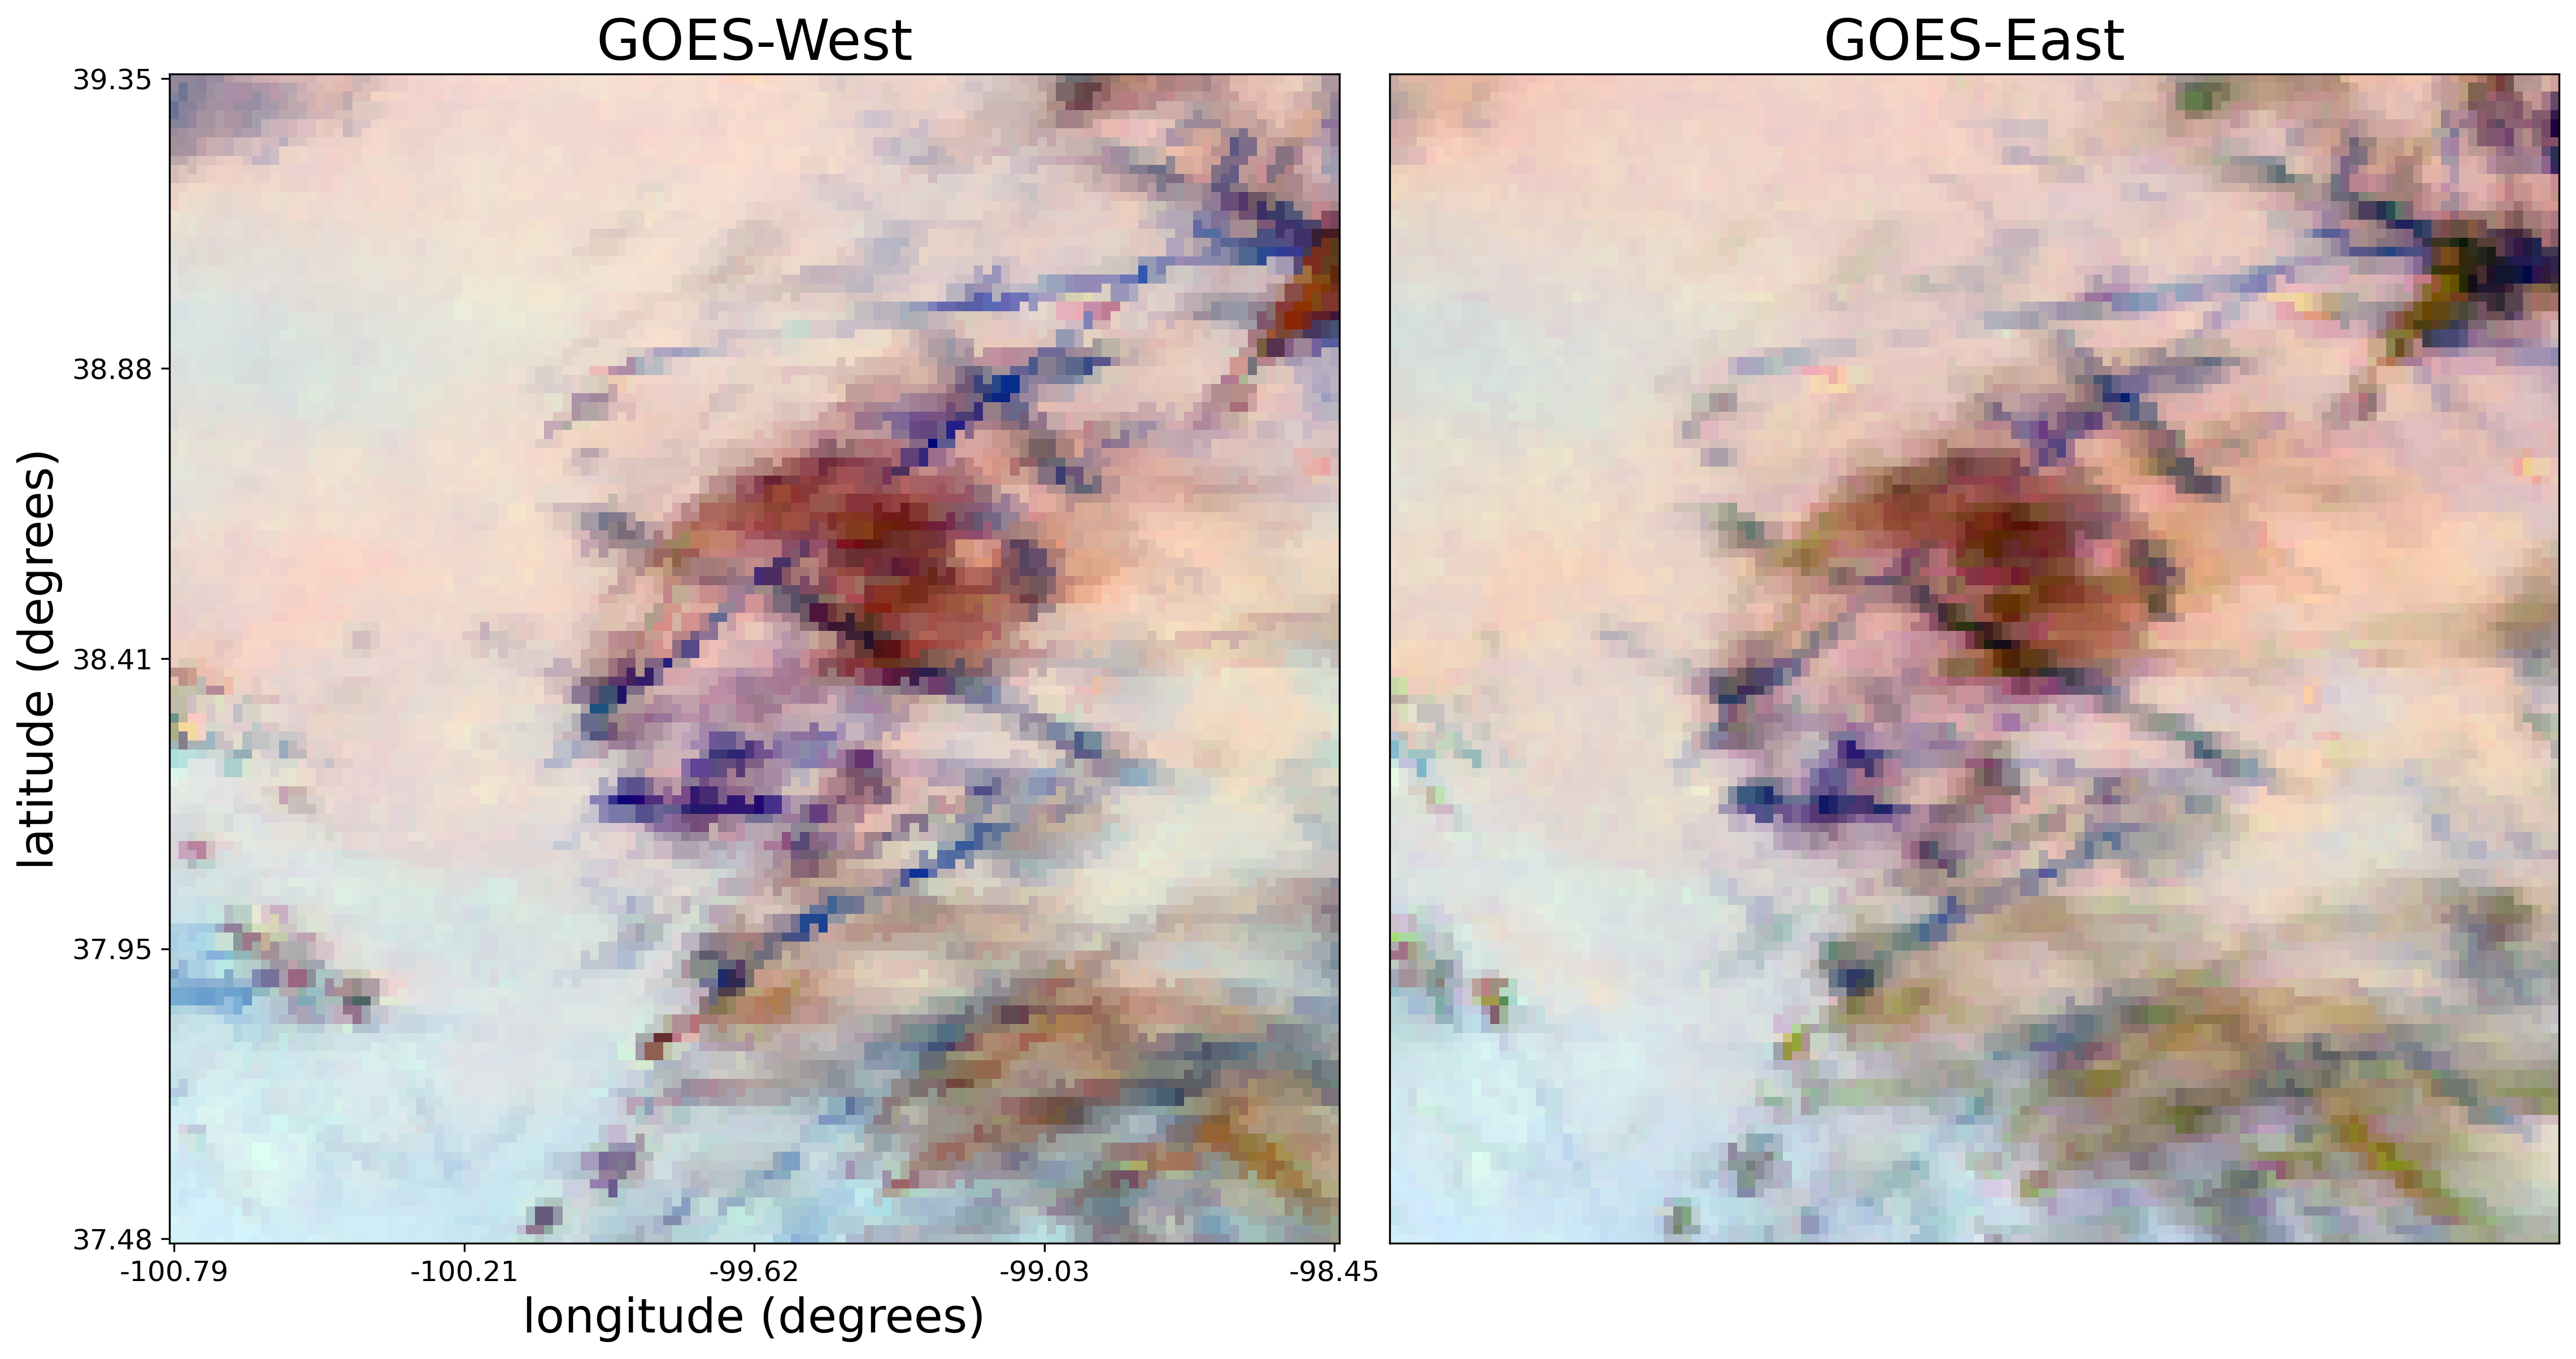

In [16]:
url = 'https://contrails.webapps.google.com/main?latitude=38.241&longitude=-99.393&zoom=50.00&imagetype=cirrus&time=1740436390'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-24 22:33:10+00:00:
sunrise is at: 2025-02-24 14:46:00+00:00
sunset is at: 2025-02-24 22:23:00+00:00
for the datetime 2025-02-24 22:33:10+00:00:
sunrise is at: 2025-02-24 14:46:00+00:00
sunset is at: 2025-02-24 22:23:00+00:00
saved file: ./data/data/ash_G18_s20250552230214_e20250552239522_38.3_-106.64.tif
saved file: ./data/coords/G18_s20250552230214_e20250552239522_38.3_-106.64.tif
saved file: ./data/data/ash_G16_s20250552230206_e20250552239514_38.3_-106.64.tif
saved file: ./data/coords/G16_s20250552230206_e20250552239514_38.3_-106.64.tif
2025/02/24 22:30 UTC


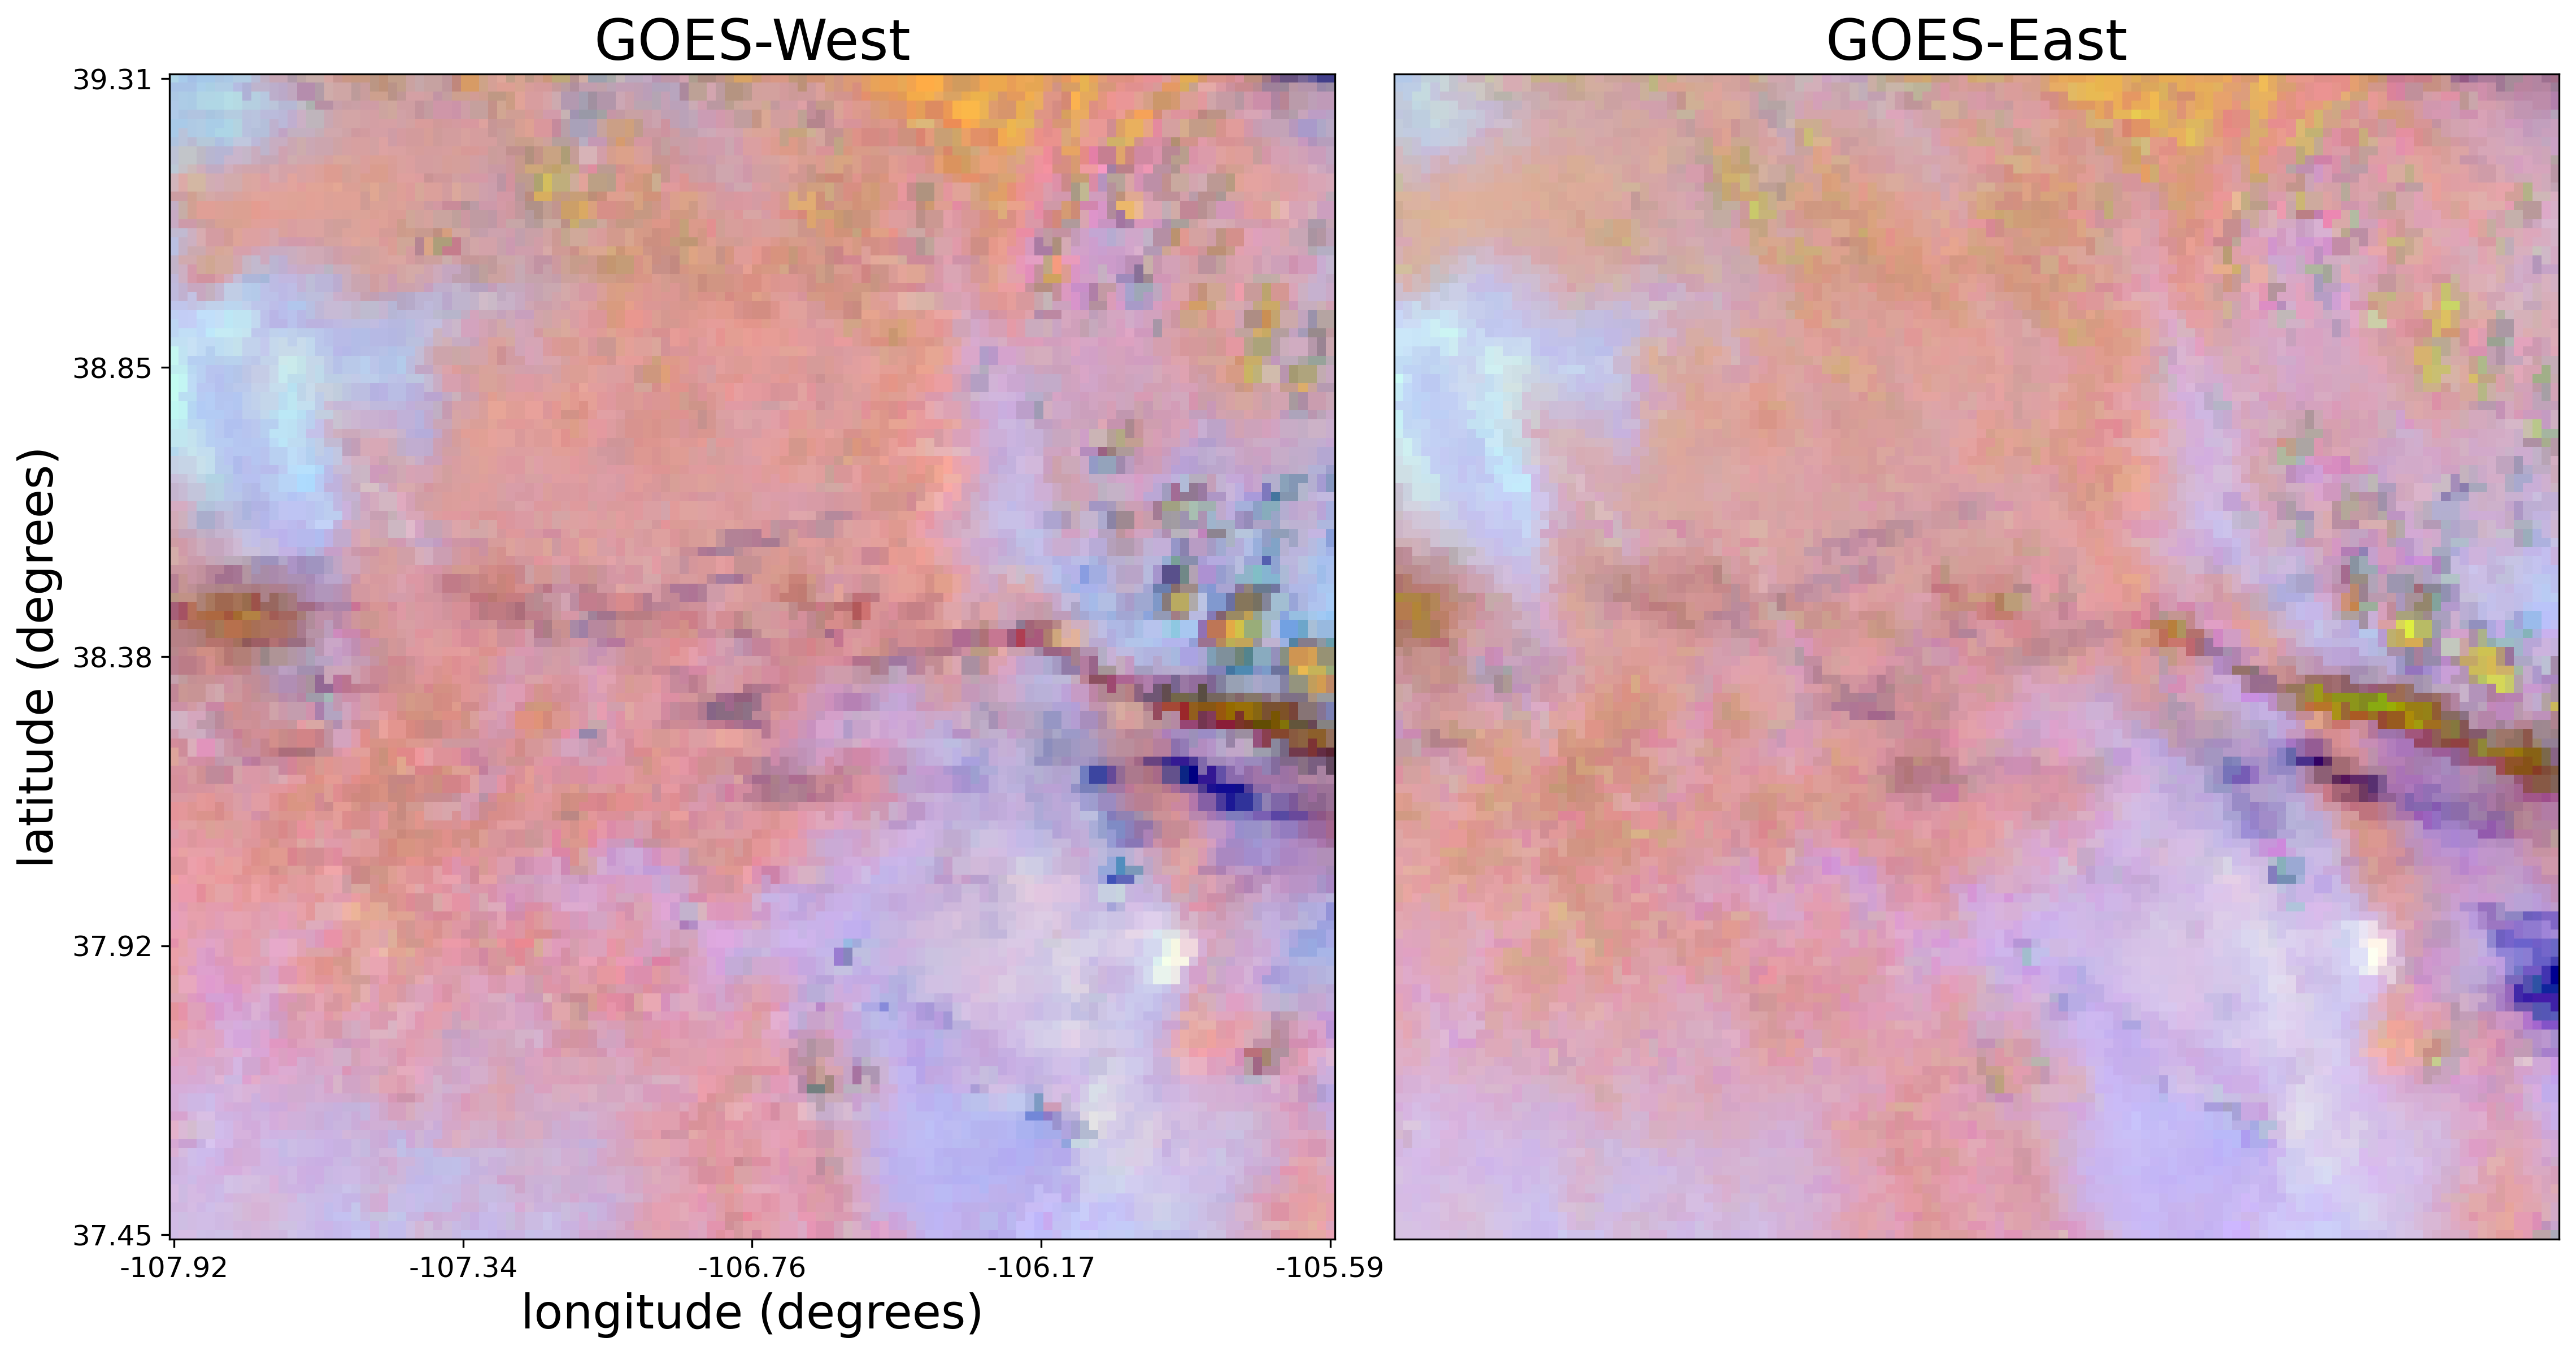

In [17]:
url = 'https://contrails.webapps.google.com/main?latitude=38.295&longitude=-106.640&zoom=50.00&imagetype=cirrus&time=1740436390'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-24 22:33:10+00:00:
sunrise is at: 2025-02-24 14:46:00+00:00
sunset is at: 2025-02-24 22:23:00+00:00
for the datetime 2025-02-24 22:33:10+00:00:
sunrise is at: 2025-02-24 14:46:00+00:00
sunset is at: 2025-02-24 22:23:00+00:00
saved file: ./data/data/ash_G18_s20250552230214_e20250552239522_38.29_-99.63.tif
saved file: ./data/coords/G18_s20250552230214_e20250552239522_38.29_-99.63.tif
saved file: ./data/data/ash_G16_s20250552230206_e20250552239514_38.29_-99.63.tif
saved file: ./data/coords/G16_s20250552230206_e20250552239514_38.29_-99.63.tif
2025/02/24 22:30 UTC


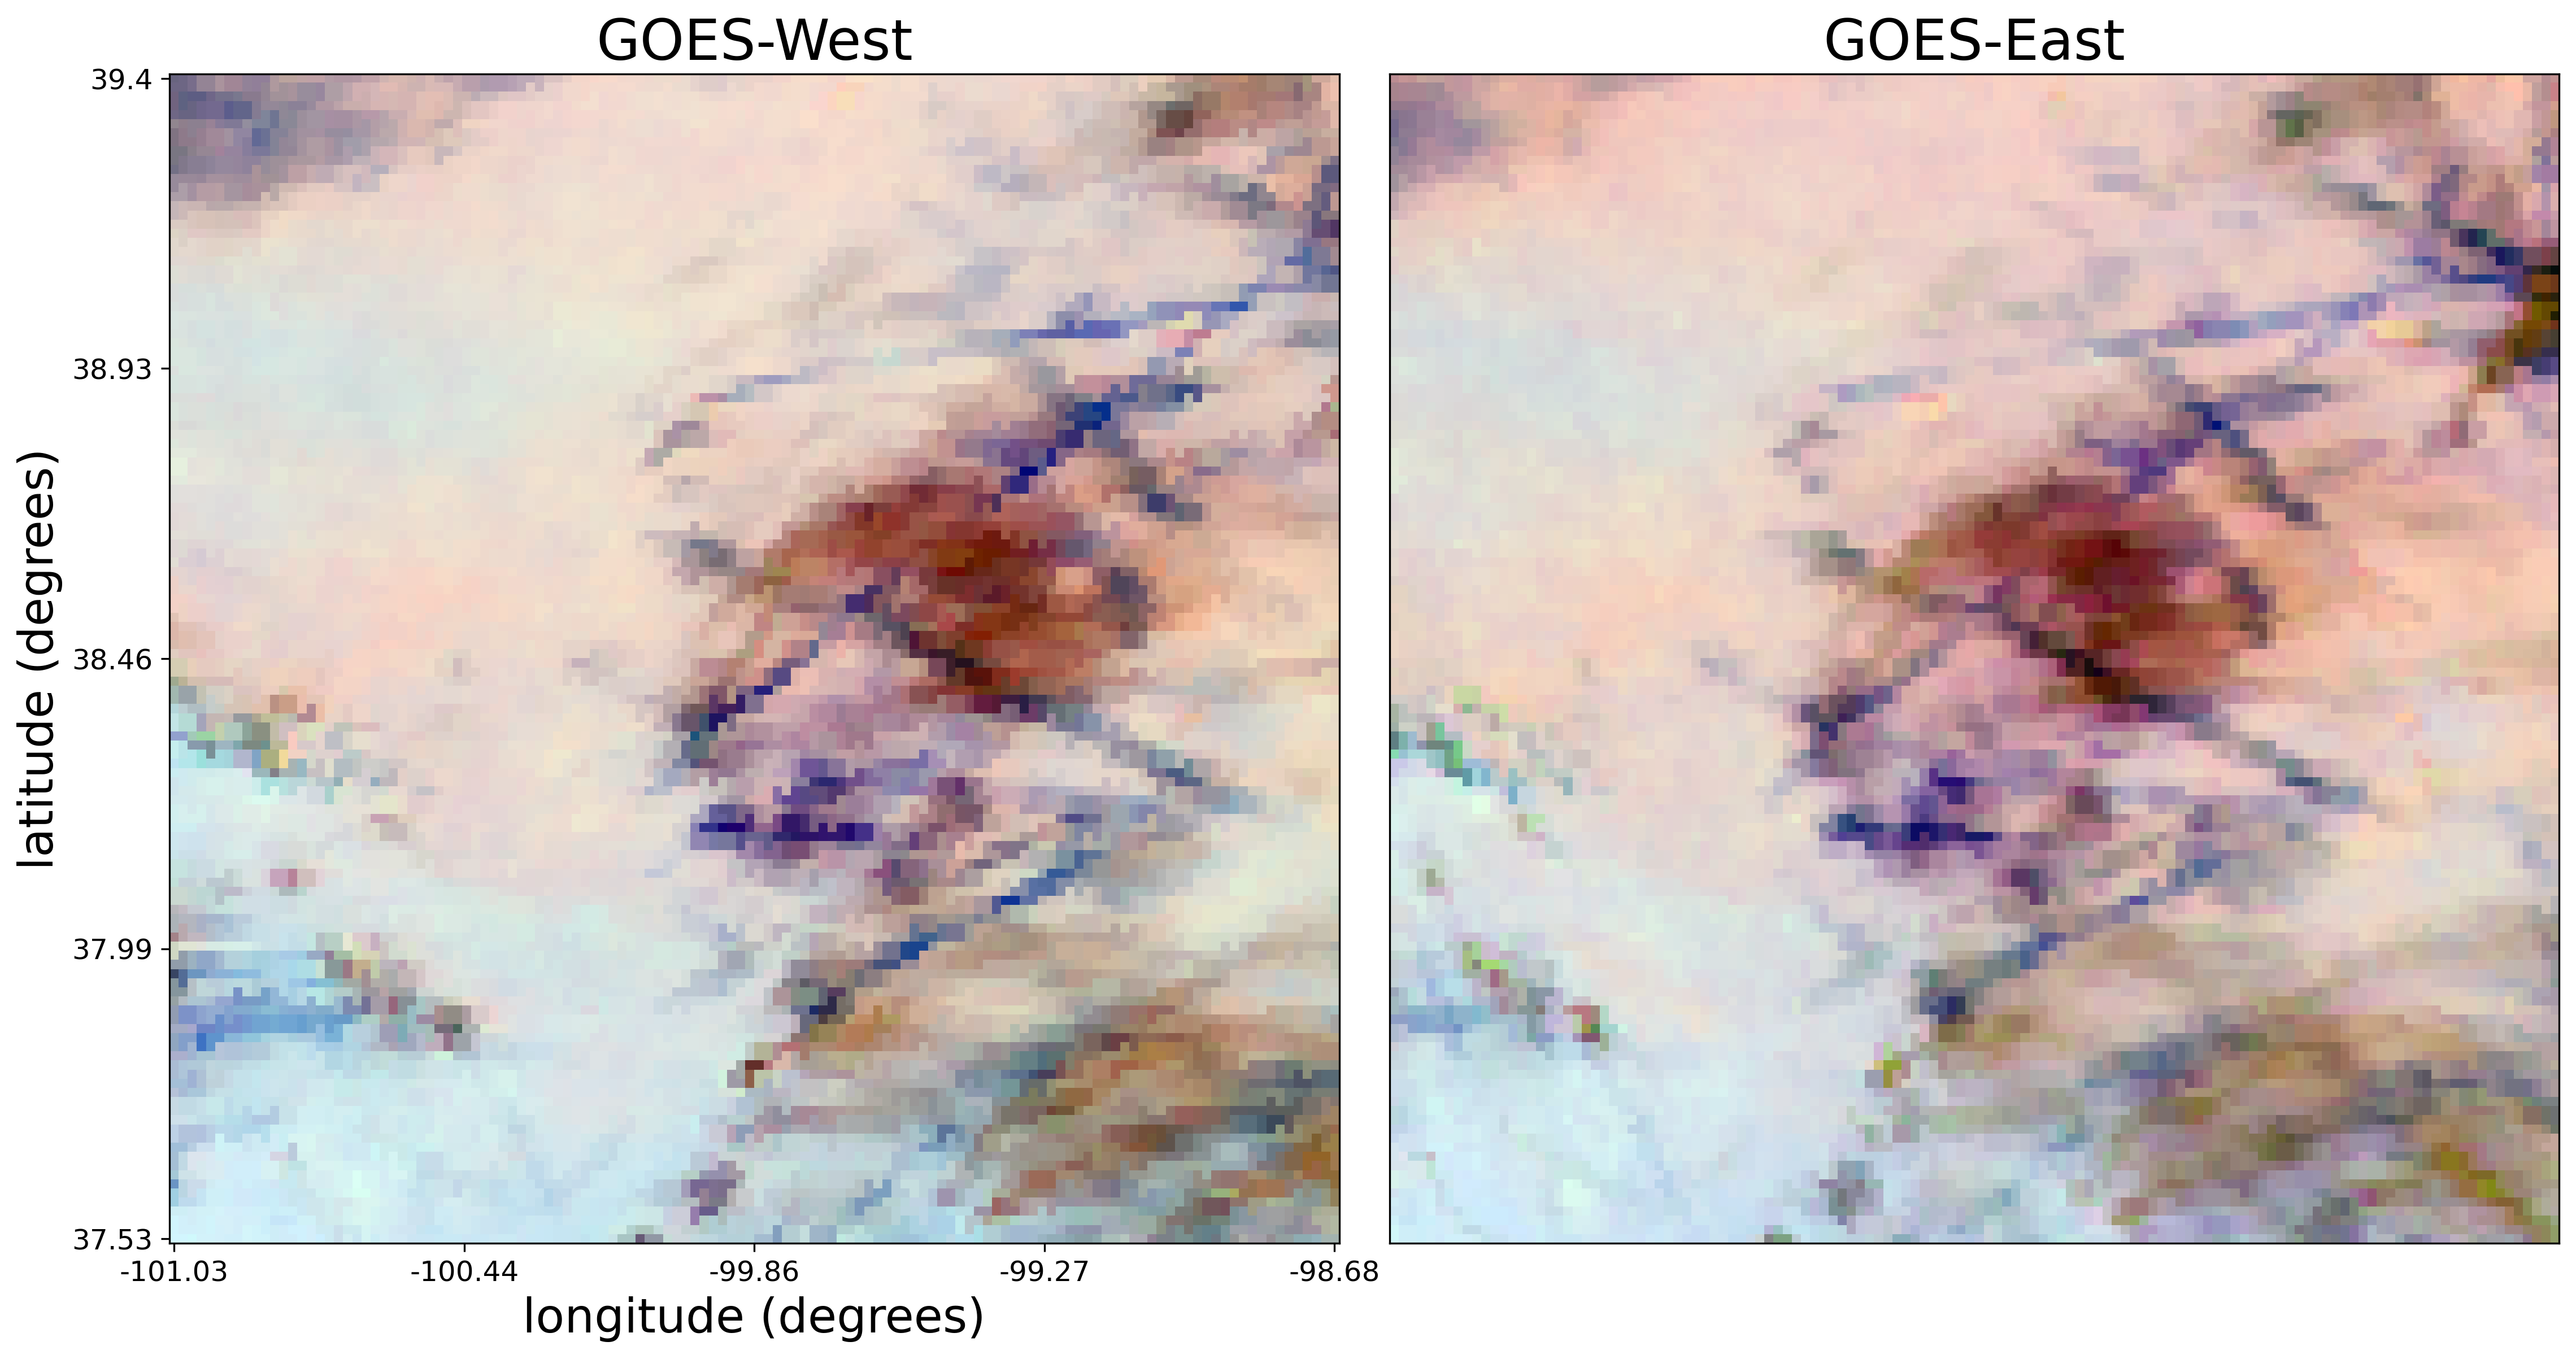

In [19]:
url = 'https://contrails.webapps.google.com/main?latitude=38.287&longitude=-99.631&zoom=15.58&imagetype=cirrus&time=1740436390'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-28 05:41:18+00:00:
sunrise is at: 2025-02-28 14:43:00+00:00
sunset is at: 2025-02-28 22:29:00+00:00
for the datetime 2025-02-28 05:41:18+00:00:
sunrise is at: 2025-02-28 14:43:00+00:00
sunset is at: 2025-02-28 22:29:00+00:00
saved file: ./data/data/ash_G18_s20250590540219_e20250590549527_42.7_-87.4.tif
saved file: ./data/coords/G18_s20250590540219_e20250590549527_42.7_-87.4.tif
saved file: ./data/data/ash_G16_s20250590540209_e20250590549518_42.7_-87.4.tif
saved file: ./data/coords/G16_s20250590540209_e20250590549518_42.7_-87.4.tif
2025/02/28 05:40 UTC


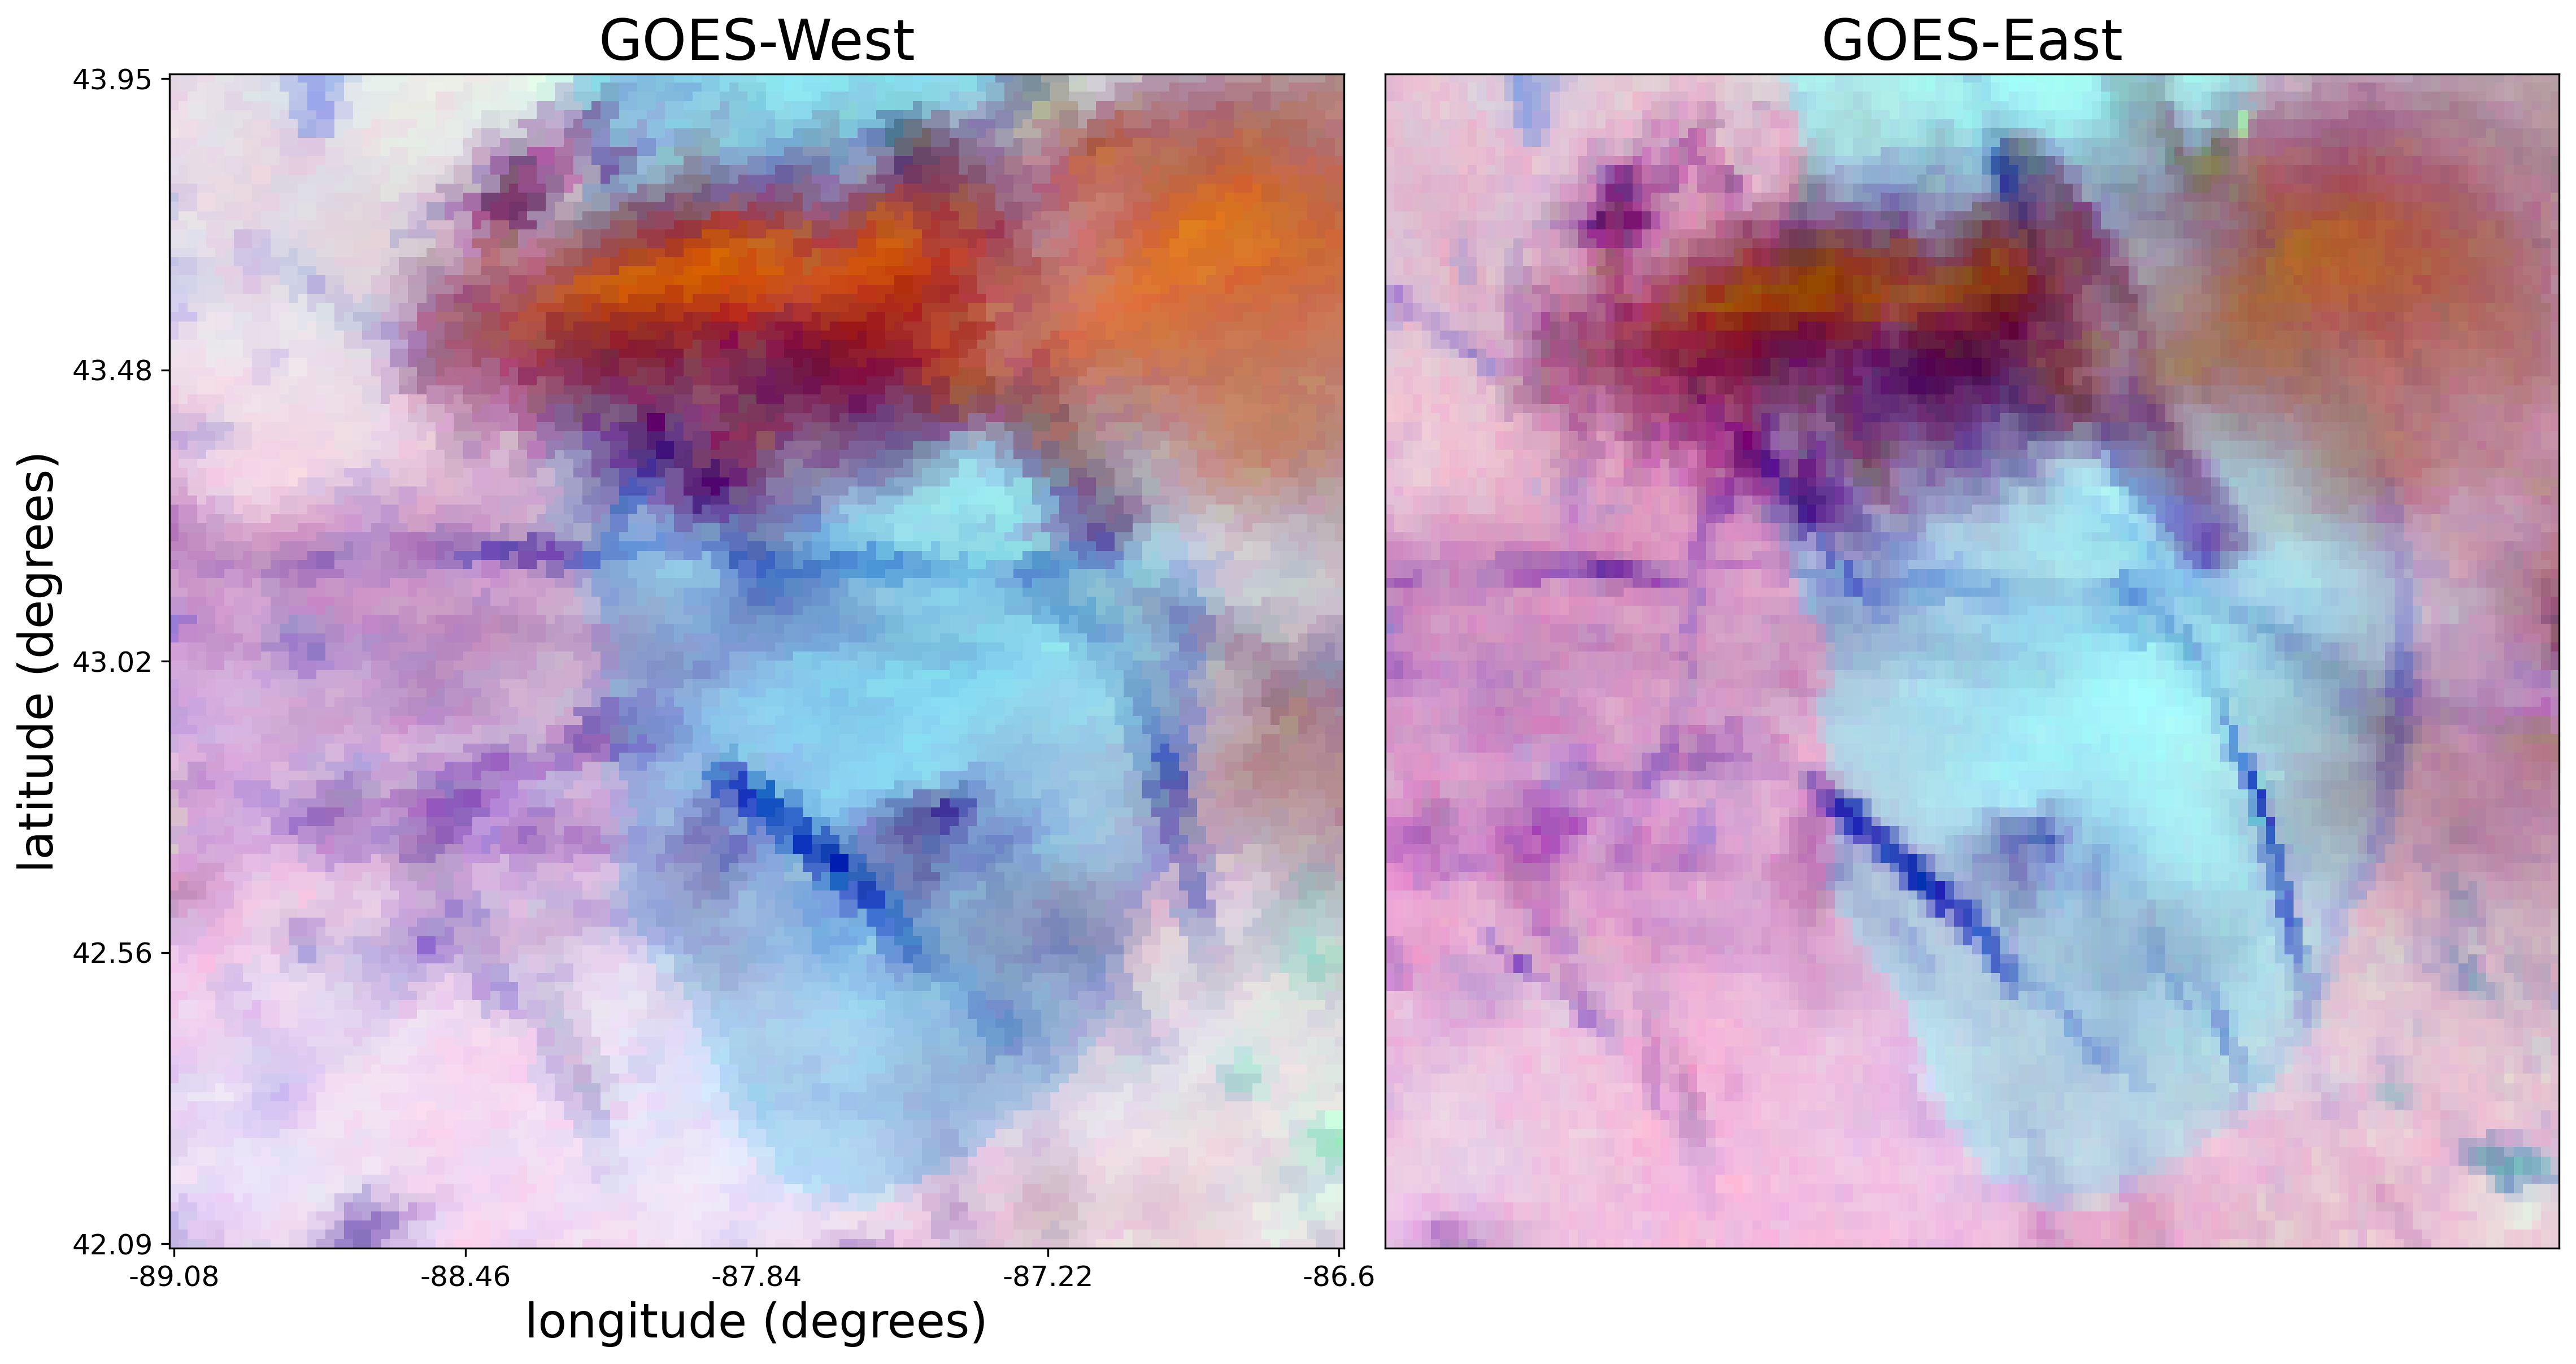

In [18]:
url = 'https://contrails.webapps.google.com/main?latitude=42.697&longitude=-87.4&zoom=12.86&imagetype=cirrus&time=1740721278'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E, save_fig_name = 'figures/superior_parallax.png')

for the datetime 2025-02-28 12:13:10+00:00:
sunrise is at: 2025-02-28 14:43:00+00:00
sunset is at: 2025-02-28 22:29:00+00:00
for the datetime 2025-02-28 12:13:10+00:00:
sunrise is at: 2025-02-28 14:43:00+00:00
sunset is at: 2025-02-28 22:29:00+00:00
saved file: ./data/data/ash_G18_s20250591210222_e20250591219530_29.58_-82.64.tif
saved file: ./data/coords/G18_s20250591210222_e20250591219530_29.58_-82.64.tif
saved file: ./data/data/ash_G16_s20250591210210_e20250591219518_29.58_-82.64.tif
saved file: ./data/coords/G16_s20250591210210_e20250591219518_29.58_-82.64.tif
2025/02/28 12:10 UTC


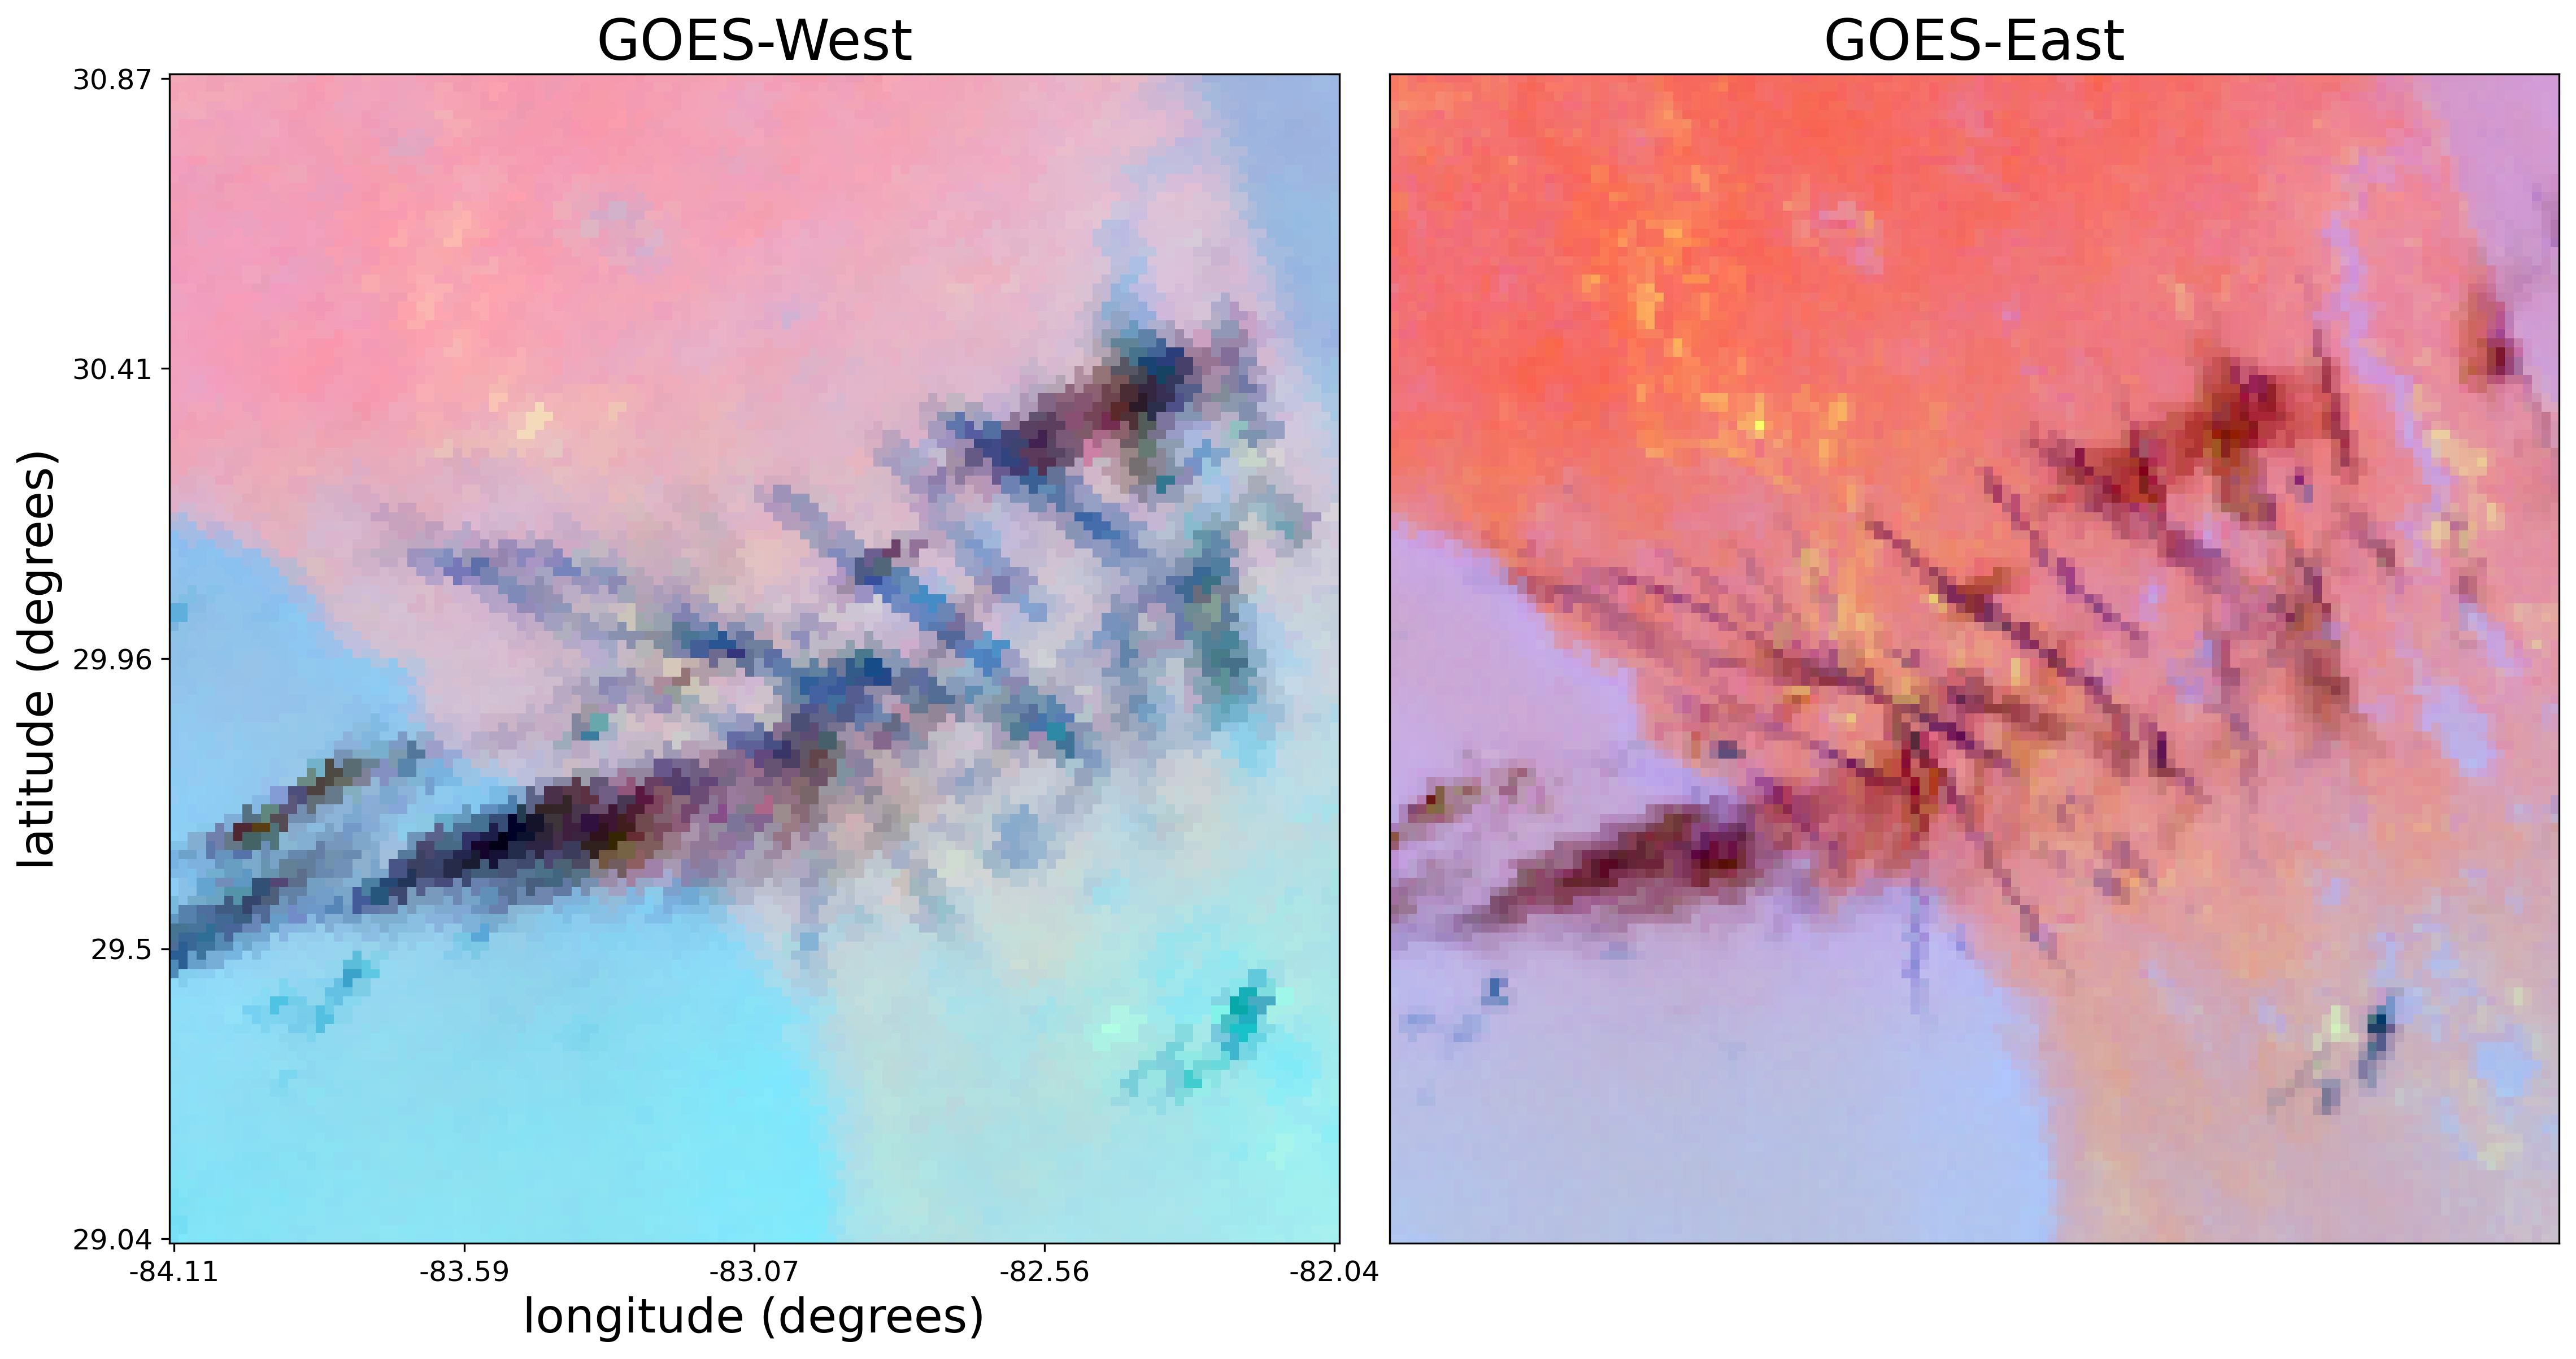

In [20]:
url = 'https://contrails.webapps.google.com/main?latitude=29.579&longitude=-82.637&zoom=50.00&imagetype=cirrus&time=1740744790'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-03-11 15:46:54+00:00:
sunrise is at: 2025-03-11 14:33:00+00:00
sunset is at: 2025-03-11 22:44:00+00:00
for the datetime 2025-03-11 15:46:54+00:00:
sunrise is at: 2025-03-11 14:33:00+00:00
sunset is at: 2025-03-11 22:44:00+00:00
saved file: ./data/data/ash_G18_s20250701550217_e20250701559526_46.37_-119.81.tif
saved file: ./data/coords/G18_s20250701550217_e20250701559526_46.37_-119.81.tif
saved file: ./data/data/ash_G16_s20250701550208_e20250701559516_46.37_-119.81.tif
saved file: ./data/coords/G16_s20250701550208_e20250701559516_46.37_-119.81.tif
2025/03/11 15:50 UTC


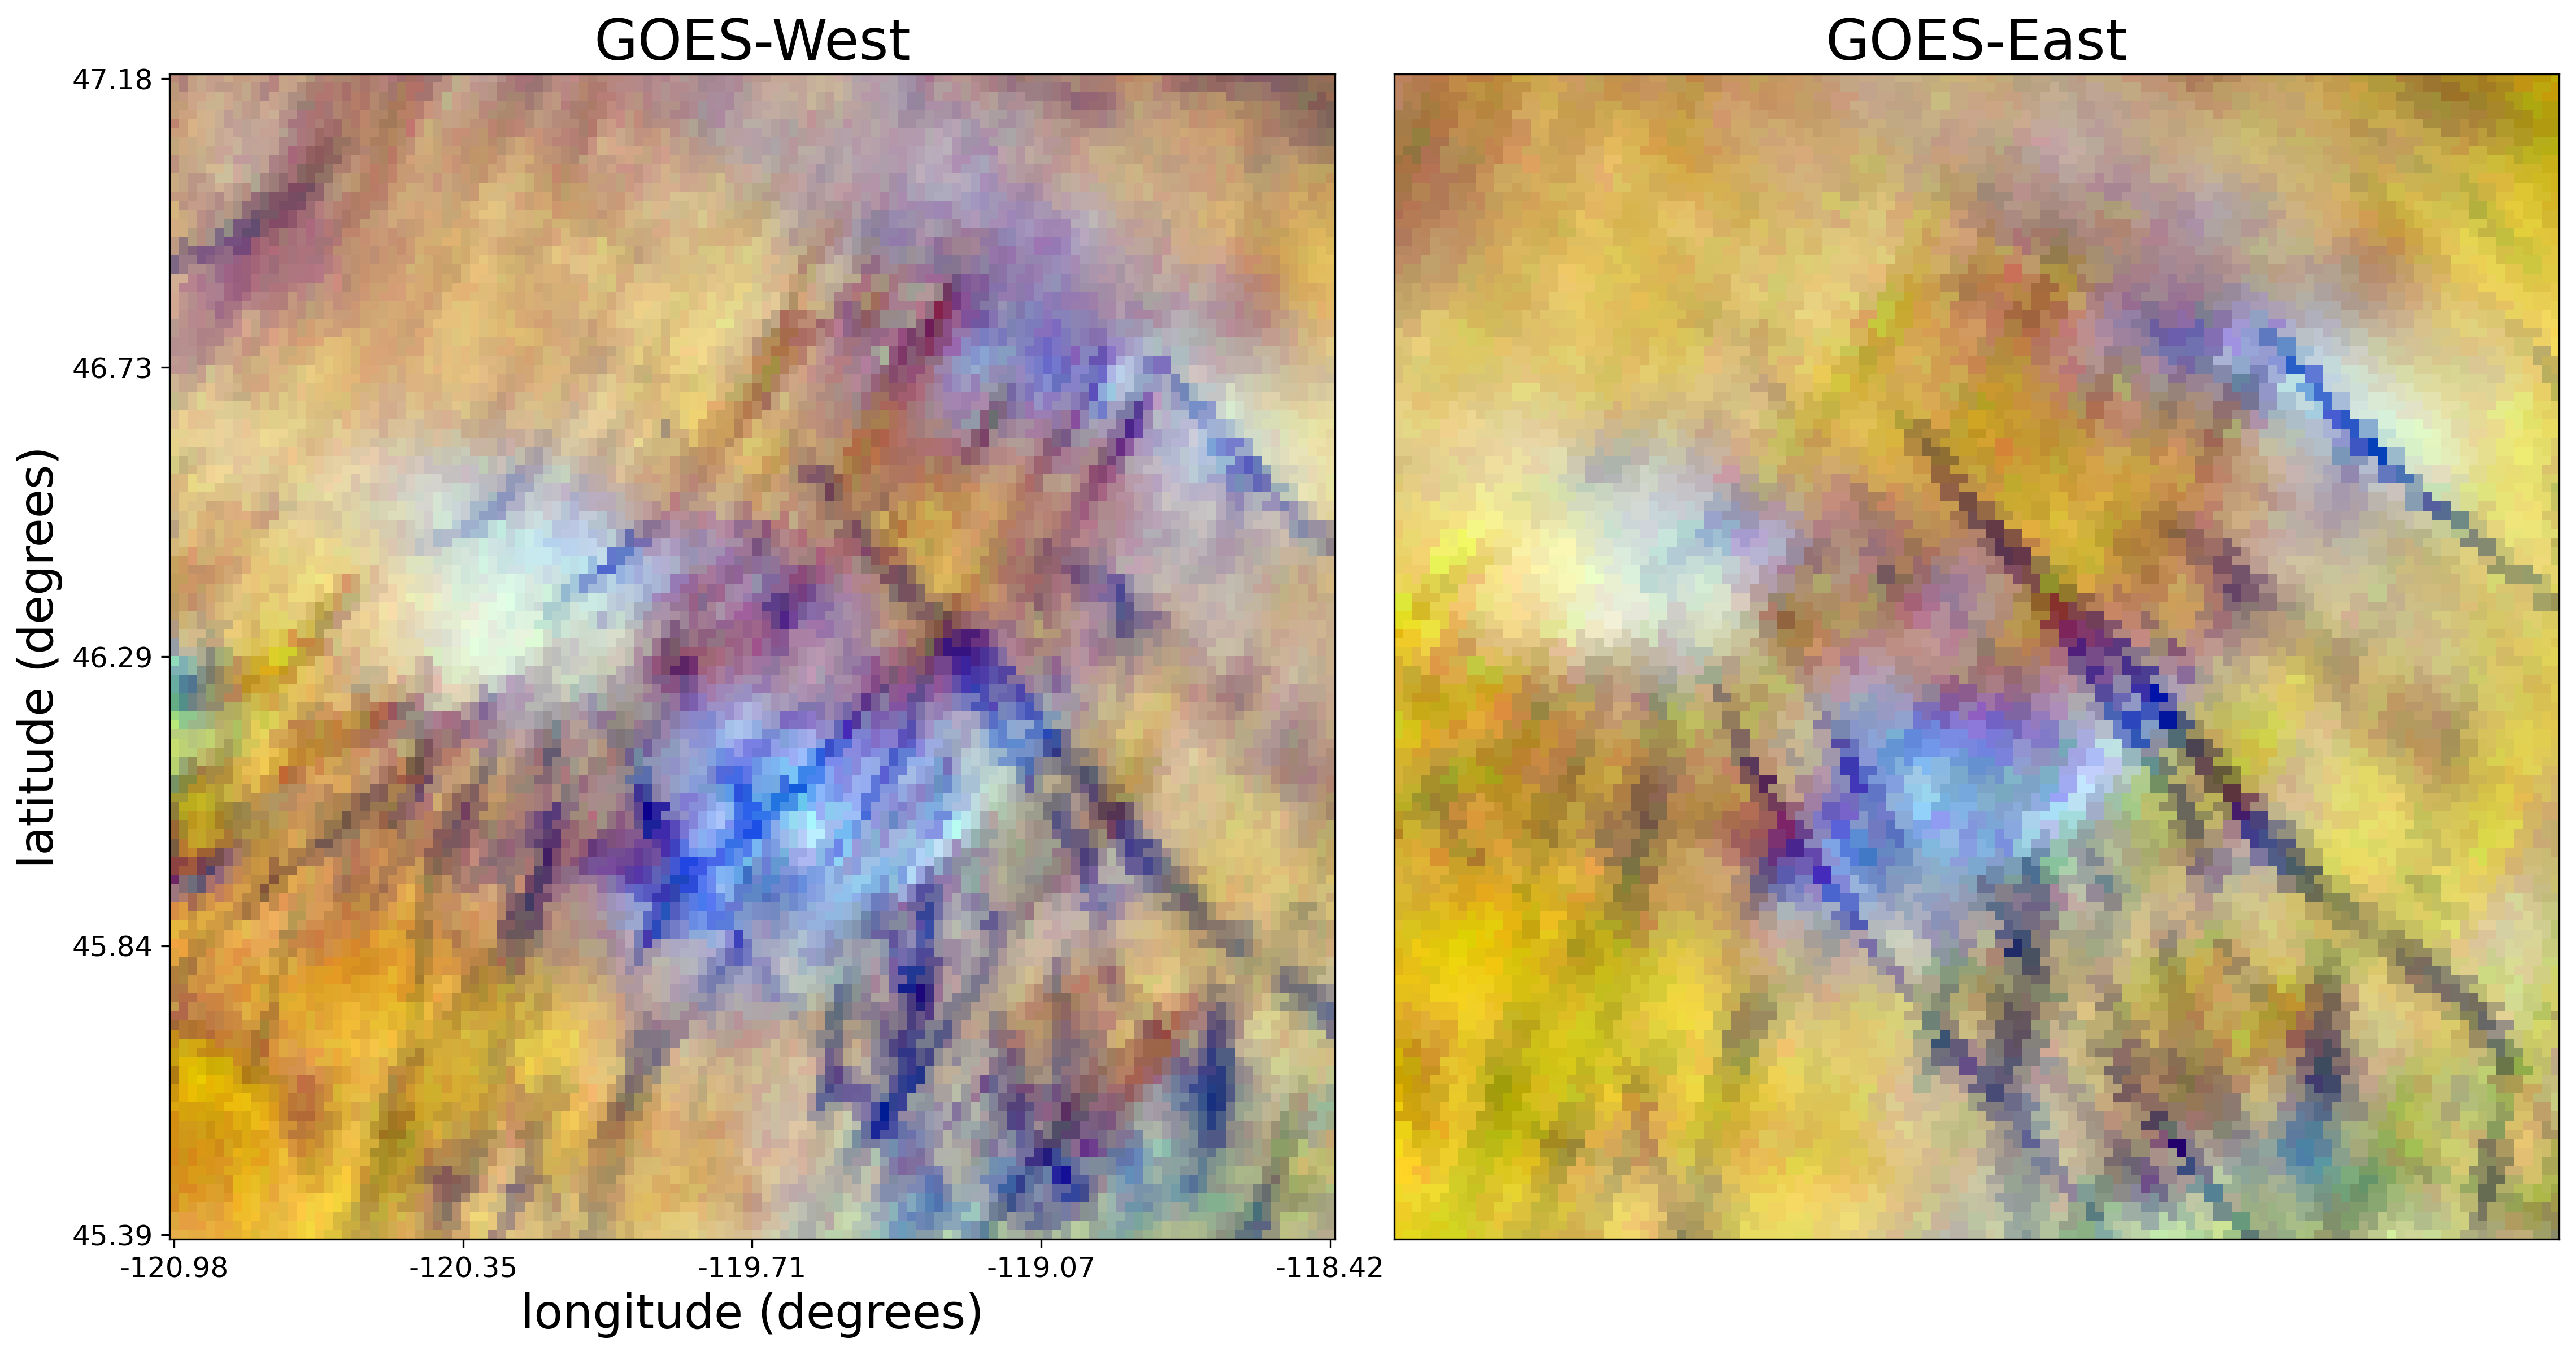

In [21]:

url = 'https://contrails.webapps.google.com/main?latitude=46.373&longitude=-119.808&zoom=50.00&imagetype=cirrus&time=1741708014'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E, save_fig_name = 'figures/west_best.png')

for the datetime 2025-02-28 13:26:55+00:00:
sunrise is at: 2025-02-28 14:43:00+00:00
sunset is at: 2025-02-28 22:29:00+00:00
OR_ABI-L1b-RadF-M6C01_G16_s20250591330210_e20250591339518_c20250591339554.nc already exists
OR_ABI-L1b-RadF-M6C02_G16_s20250591330210_e20250591339518_c20250591339543.nc already exists
OR_ABI-L1b-RadF-M6C03_G16_s20250591330210_e20250591339518_c20250591339558.nc already exists
OR_ABI-L1b-RadF-M6C04_G16_s20250591330210_e20250591339518_c20250591339537.nc already exists
OR_ABI-L1b-RadF-M6C05_G16_s20250591330210_e20250591339518_c20250591339563.nc already exists
OR_ABI-L1b-RadF-M6C06_G16_s20250591330210_e20250591339523_c20250591339547.nc already exists
OR_ABI-L1b-RadF-M6C07_G16_s20250591330210_e20250591339529_c20250591339567.nc already exists
OR_ABI-L1b-RadF-M6C08_G16_s20250591330210_e20250591339518_c20250591339570.nc already exists
OR_ABI-L1b-RadF-M6C09_G16_s20250591330210_e20250591339523_c20250591339564.nc already exists
OR_ABI-L1b-RadF-M6C10_G16_s20250591330210_e2025

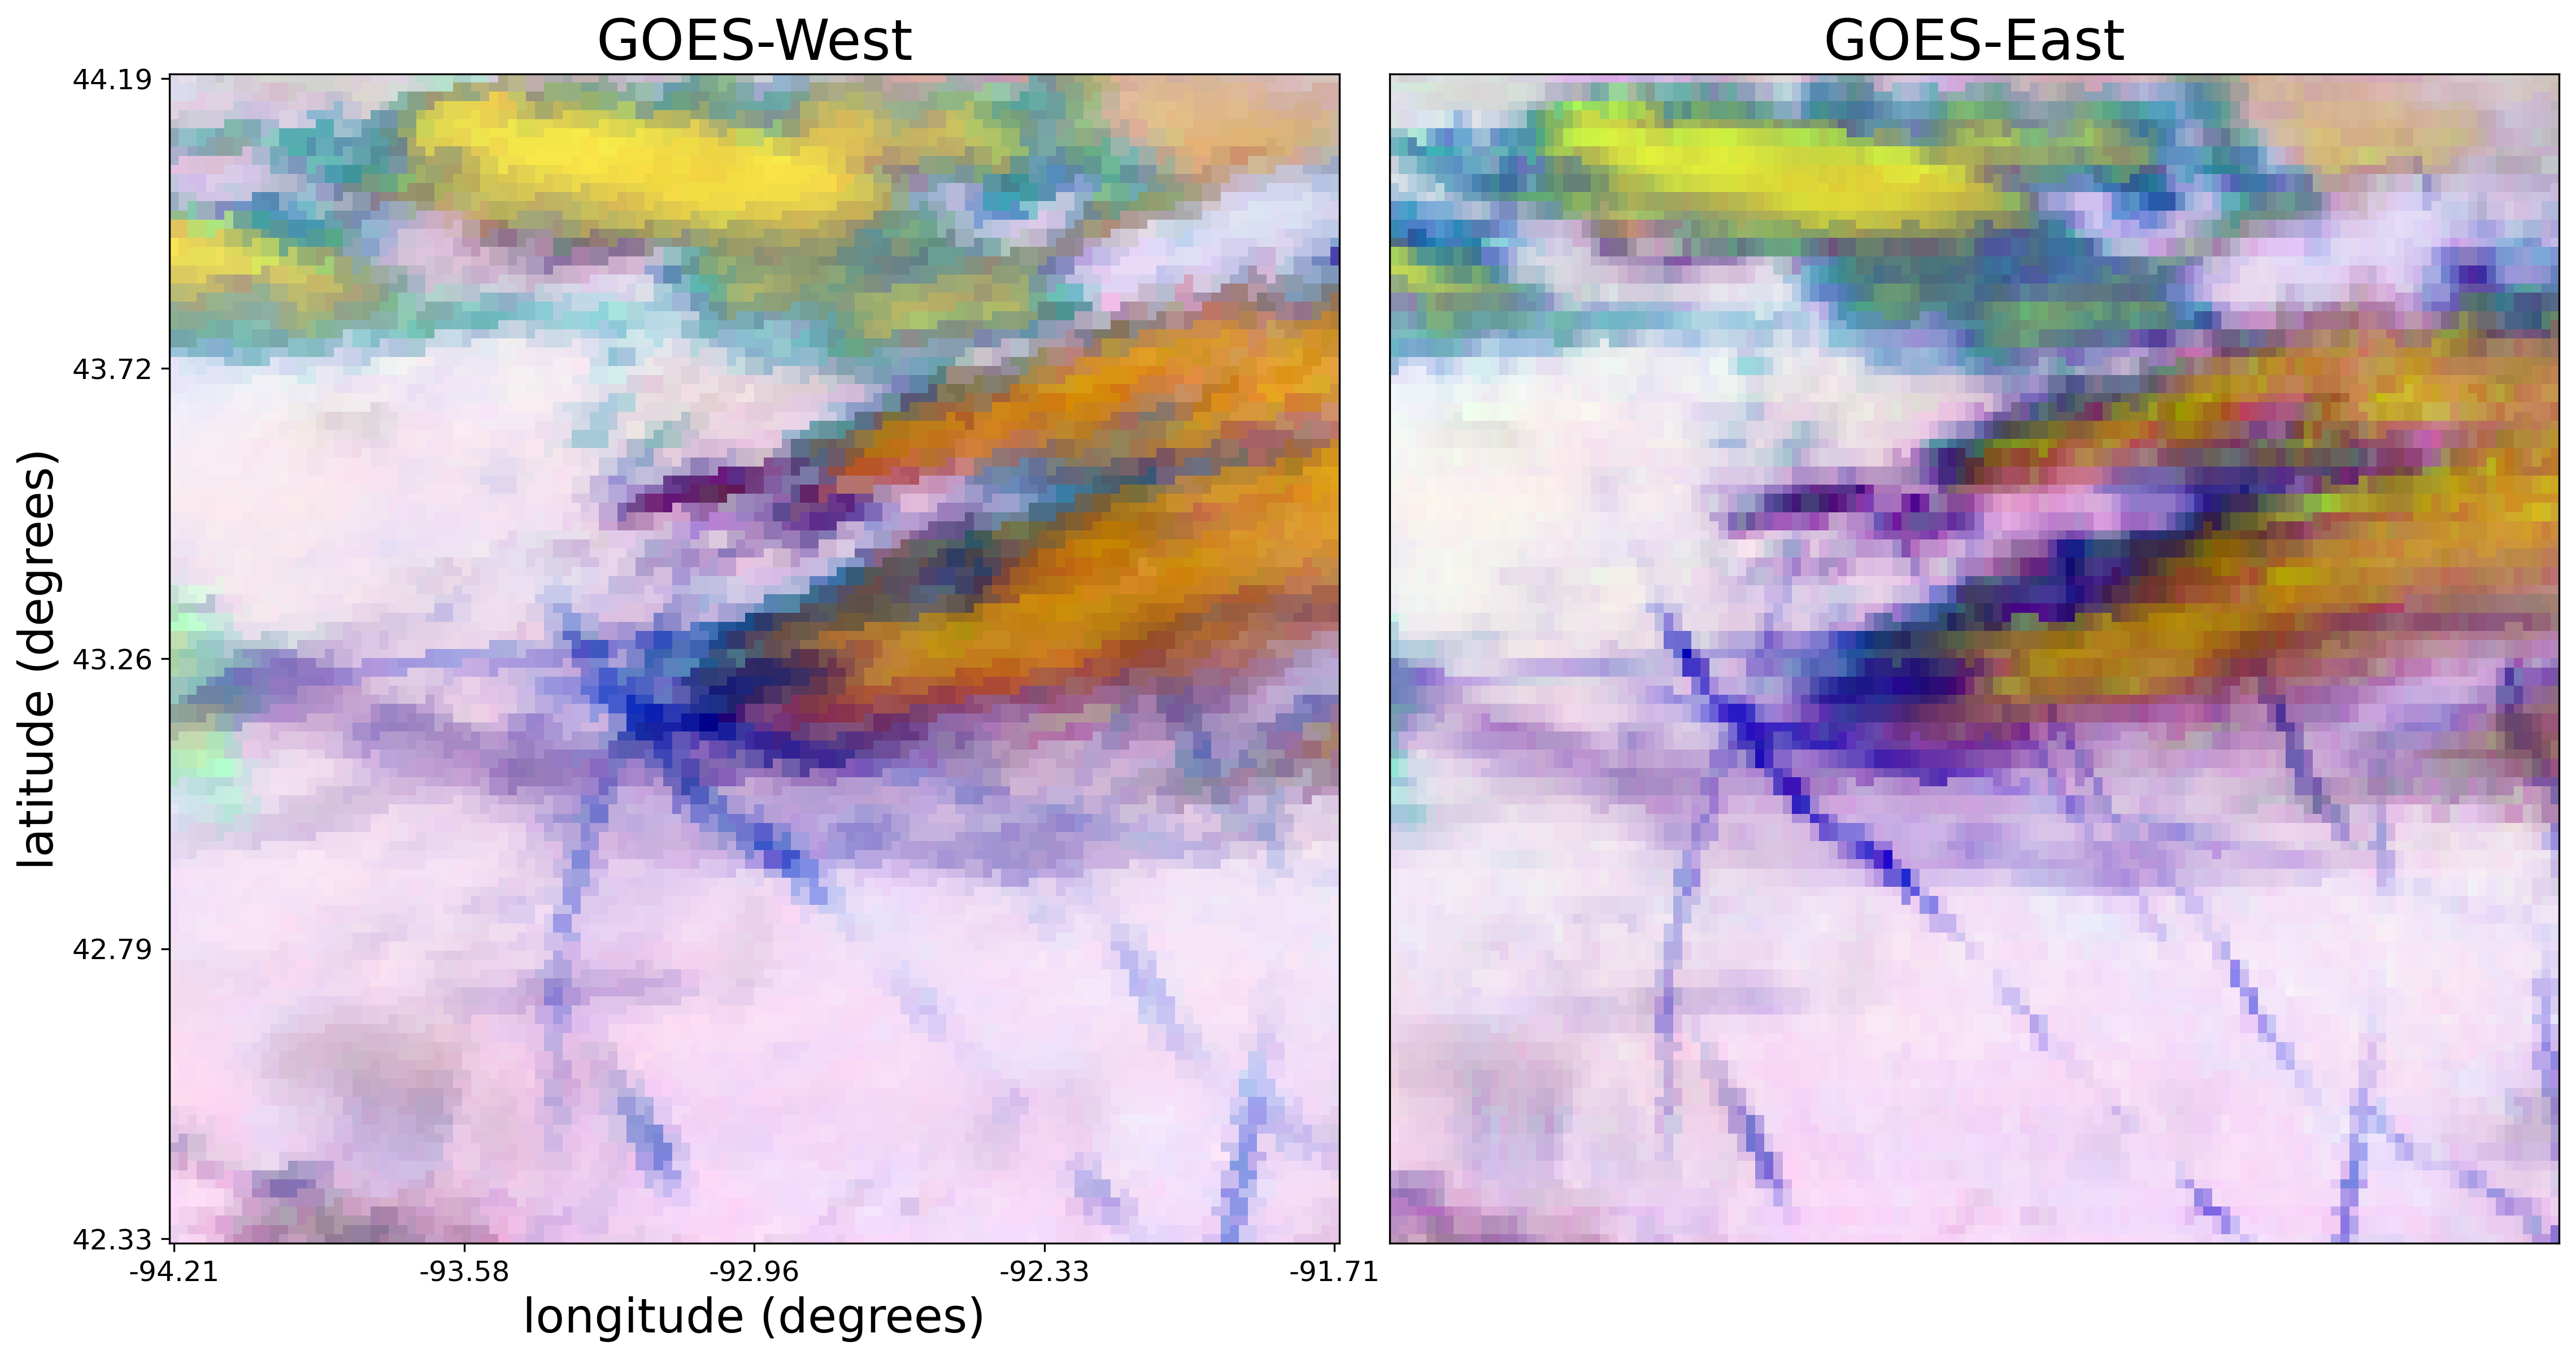

In [75]:
url = 'https://contrails.webapps.google.com/main?latitude=43.0&longitude=-92.6&zoom=22.94&imagetype=cirrus&time=1740749215'
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E, save_fig_name = 'figures/east_best.png')

In [ ]:
url = ''
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

In [ ]:
url = ''
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

In [ ]:
url = ''
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

In [ ]:
url = ''
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

In [ ]:
url = ''
lat, lon, dt = get_lat_lon_dt_from_url(url)
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)